# Simple Linear Regression Models

In [22]:
# Carregar Bibliotecas
library(dplyr)
library(xts)
library(ggplot2)
library(forecast)
library(tidyverse)

In [2]:
path <- "https://raw.githubusercontent.com/E-man85/projectII/main/dataStaging/grainWeekMultipleVariables.csv"
df <- read.csv(path)
df <- df[, c('store_id','date', 'summed_revenue')]
rm(path)
head(df)
str(df)
dim(df)

,store_id,date,summed_revenue
,<chr>,<chr>,<dbl>
1,S0002,2017-01-08,1813.24
2,S0002,2017-01-15,1896.91
3,S0002,2017-01-22,7404.16
4,S0002,2017-01-29,2078.39
5,S0002,2017-02-05,1745.47
6,S0002,2017-02-12,2235.39


'data.frame':	8301 obs. of  3 variables:
 $ store_id      : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date          : chr  "2017-01-08" "2017-01-15" "2017-01-22" "2017-01-29" ...
 $ summed_revenue: num  1813 1897 7404 2078 1745 ...


[1] 8301    3

## Data Preparation

In [3]:
# Alterar tipo da coluna date
df$date <- as.Date(df$date)
# criar variável com lista das lojas unicas
stores <- unique(df$store_id)
# Lista para armazenar os dataframes
df_list <- list()
# Loop para criar os dataframes separados
for (store in stores) {
  # filtrar dataframe
  df_store <- df[df$store_id == store,]
  # Adicionar dataframe à lista
  df_list[[store]] <- df_store
}
# Dividir dados treino e teste
# lista para armazenar os timeseries teste e treino
df_train <- list()
df_test <- list()
# Loop para criar as séries temporais semanais e armazenar nas lista
for (t in names(df_list)) {
  data <- df_list[[t]]
  train <- head(data, -5)
  test <- tail(data, 5)
  df_train[[t]] <- train
  df_test[[t]] <- test
}
# Converter em timeseries ts
# lista para armazenar os timeseries 
ts_real <- list()
ts_train <- list()
ts_test <- list()
# Loop
for(t in names(df_list)){
    data <- df_list[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_real[[t]] <- ts
}
# Loop
for(t in names(df_train)){
    data <- df_train[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_train[[t]] <- ts
}
# Loop
for(t in names(df_test)){
    data <- df_test[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_test[[t]] <- ts
}
length(ts_train)
length(ts_test)
length(ts_real)

[1] 63

[1] 63

[1] 63

## Models TSLM (Time Series Linear Model)

In [4]:
# Model tslm com e sem 'season'
# Armazenar previsões tslm model 
tslm_prev <- list()
# Loop
for (ts in names(ts_train)){
  if (ts %in% c( "S0007","S0109")) {
    data <- ts_train[[ts]]
    model_tslm <- tslm(data ~ trend)
    forecast_result <- forecast(model_tslm, h = 5) 
    tslm_prev[[ts]] <- round(forecast_result$mean,2)
  } else {
    data <- ts_train[[ts]]
    model_tslm <- tslm(data ~ trend + season)
    forecast_result <- forecast(model_tslm, h = 5)
    tslm_prev[[ts]] <- round(forecast_result$mean,2)
  }
}
length(tslm_prev)

[1] 63

O modelo TSLM assume uma relação linear entre a série temporal e as variáveis explicativas trend e season. como alguma lojas não têm dados para relacionar a season fei feita apenas com a trend.

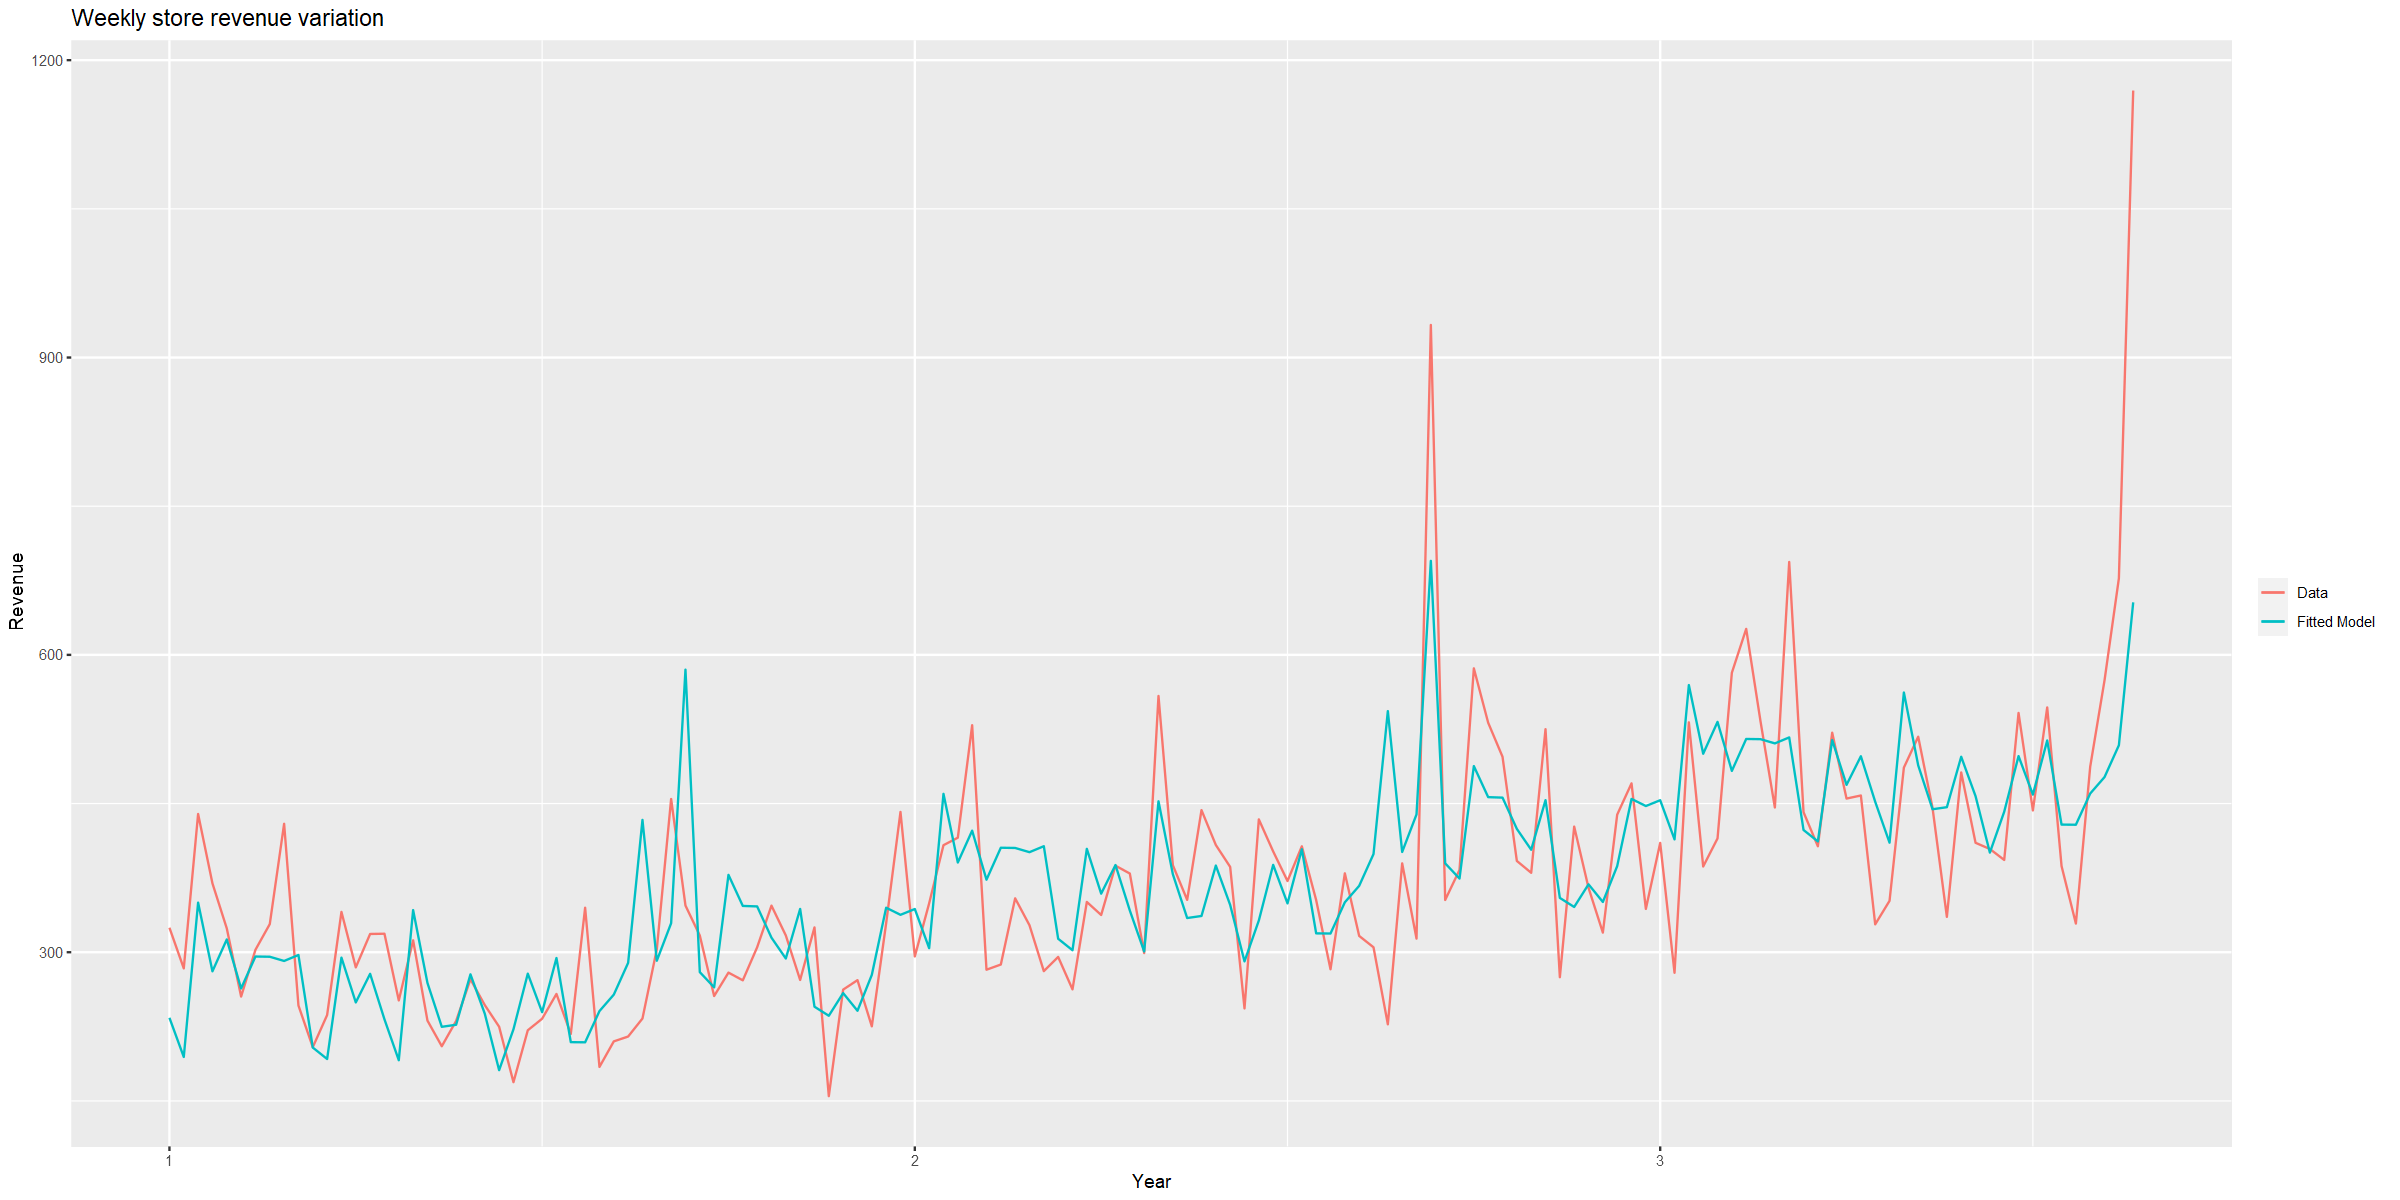

In [5]:
# Ver variação do Revenue dados modelo vs dados reais
options(repr.plot.width = 20, repr.plot.height = 10)
autoplot(data, series="Data") +
  autolayer(fitted(model_tslm), series="Fitted Model") +
  xlab("Year") + ylab("Revenue") +
  ggtitle("Weekly store revenue variation") +
  guides(colour=guide_legend(title=" "))

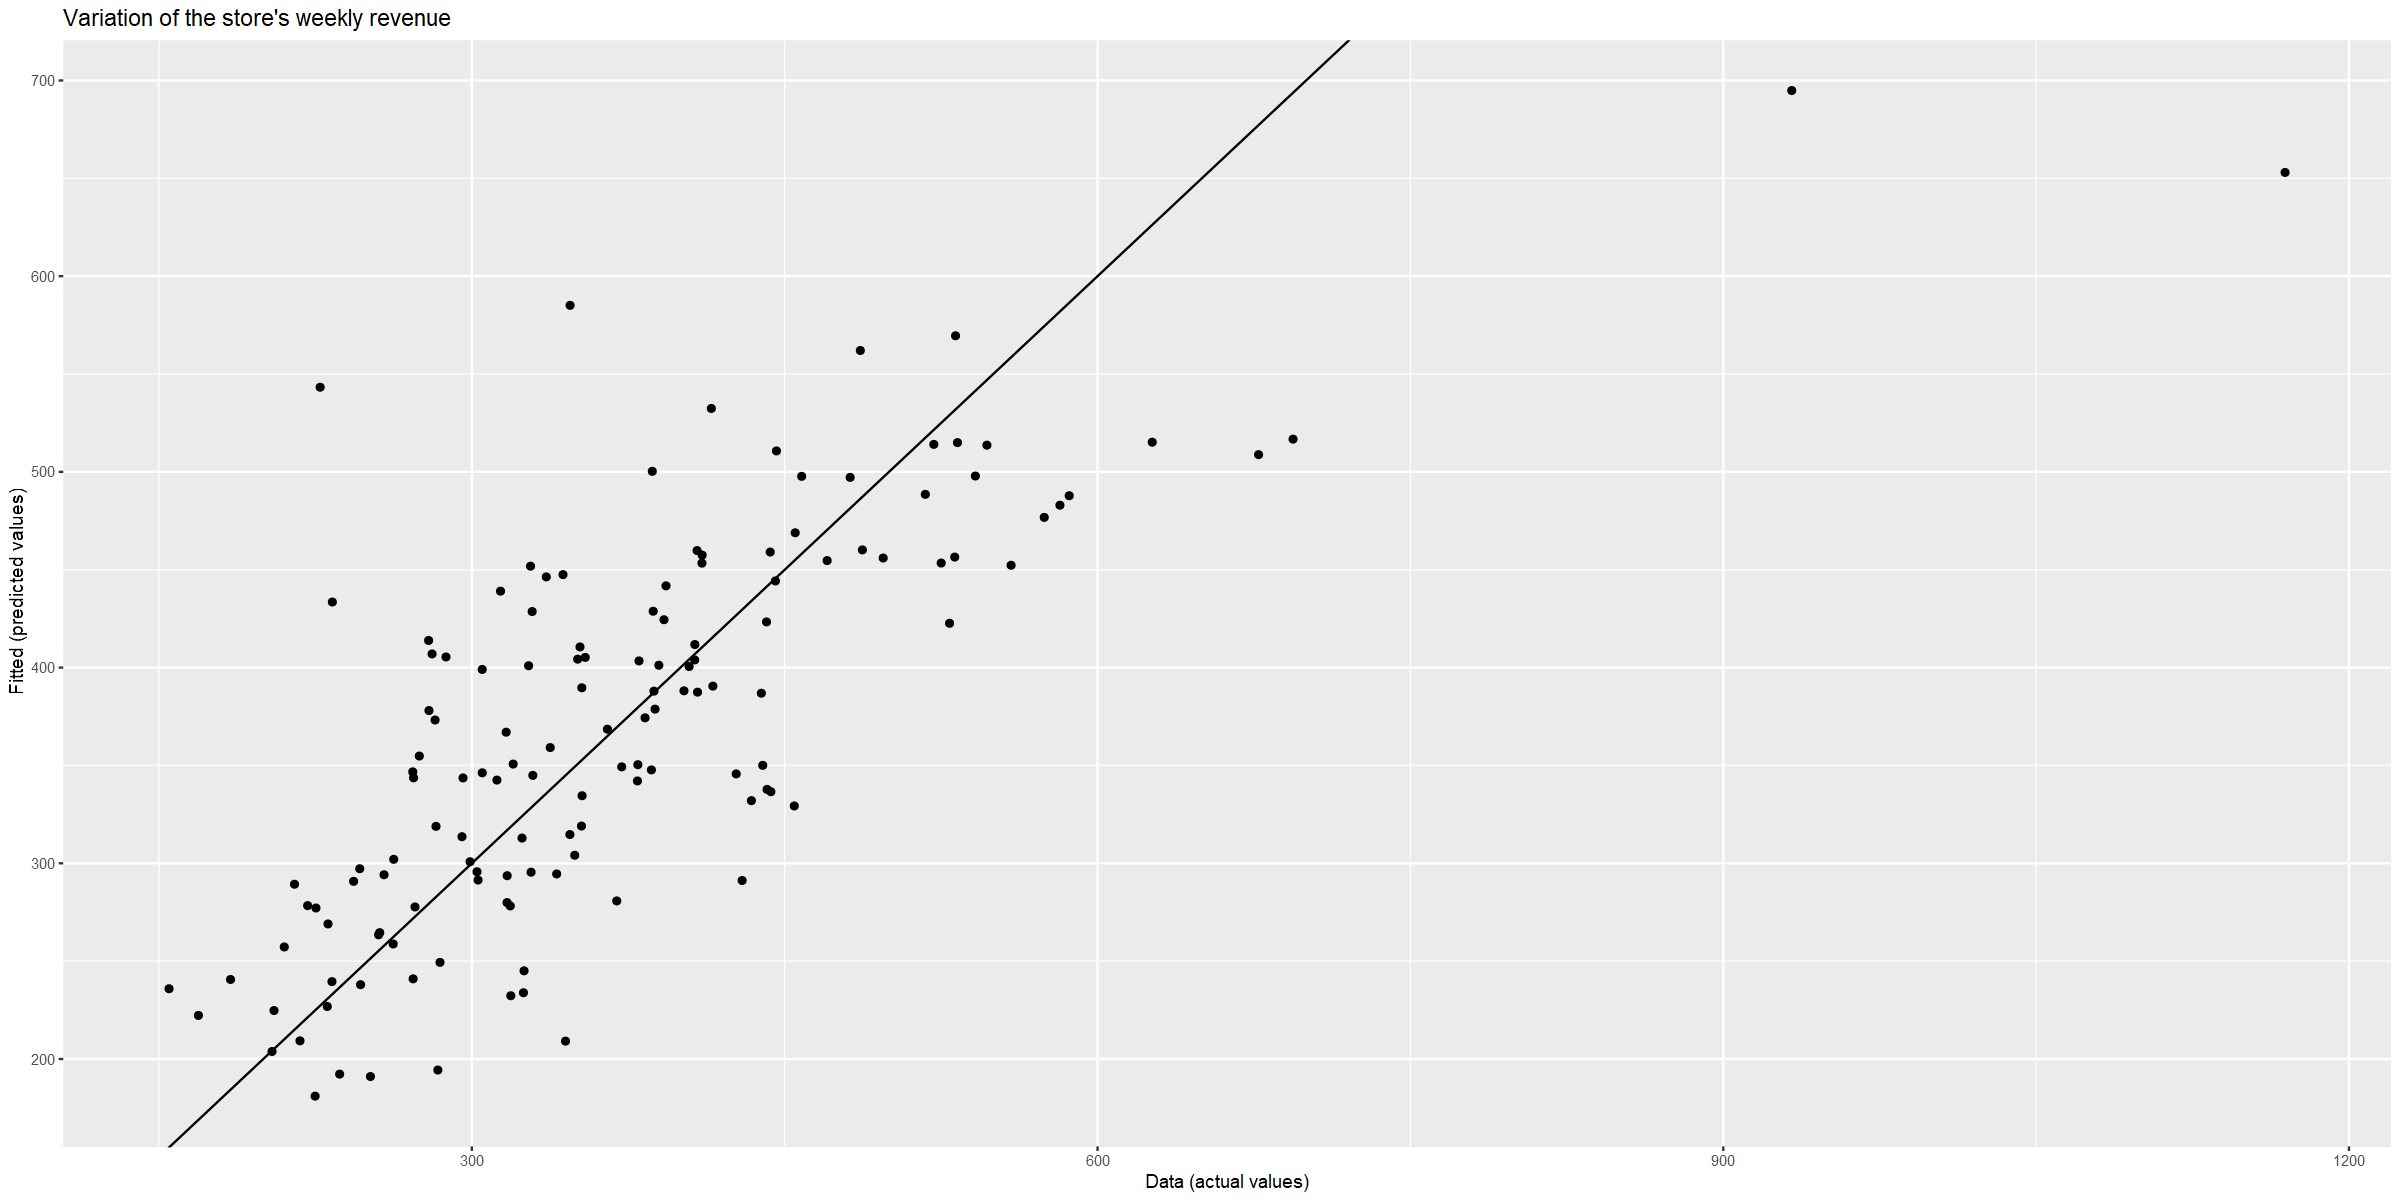

In [6]:
#  linha de regressão com intercepto zero e inclinação um, 
#que representa a linha de referência para os valores reais e previsões serem iguais
options(repr.plot.width = 20, repr.plot.height = 10)
cbind(Data = data,
      Fitted = fitted(model_tslm)) %>%
  as.data.frame() %>%
  ggplot(aes(x=Data, y=Fitted)) +
    geom_point() +
    ylab("Fitted (predicted values)") +
    xlab("Data (actual values)") +
    ggtitle("Variation of the store's weekly revenue") +
    geom_abline(intercept=0, slope=1)

In [7]:
# Resumo modelo ex: loja S0143
summary(model_tslm)


Call:
tslm(formula = data ~ trend + season)

Residuals:
    Min      1Q  Median      3Q     Max 
-315.98  -48.46   -0.14   38.11  516.36 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  231.7479    67.0309   3.457 0.000854 ***
trend          2.1106     0.2494   8.461 6.65e-13 ***
season2      -41.6139    92.9342  -0.448 0.655452    
season3      111.9655    92.9352   1.205 0.231636    
season4       40.5815    92.9369   0.437 0.663468    
season5       70.5876    92.9393   0.760 0.449653    
season6       19.0470    92.9423   0.205 0.838114    
season7       49.1530    92.9460   0.529 0.598298    
season8       46.8191    92.9503   0.504 0.615775    
season9       40.4552    92.9553   0.435 0.664513    
season10      44.3679    92.9610   0.477 0.634392    
season11     -51.1294    92.9674  -0.550 0.583781    
season12     -64.8000    92.9744  -0.697 0.487726    
season13      35.3627    92.9821   0.380 0.704658    
season14     -11.9279    92.9905  -0


	Breusch-Godfrey test for serial correlation of order up to 56

data:  Residuals from Linear regression model
LM test = 117.64, df = 56, p-value = 2.829e-06


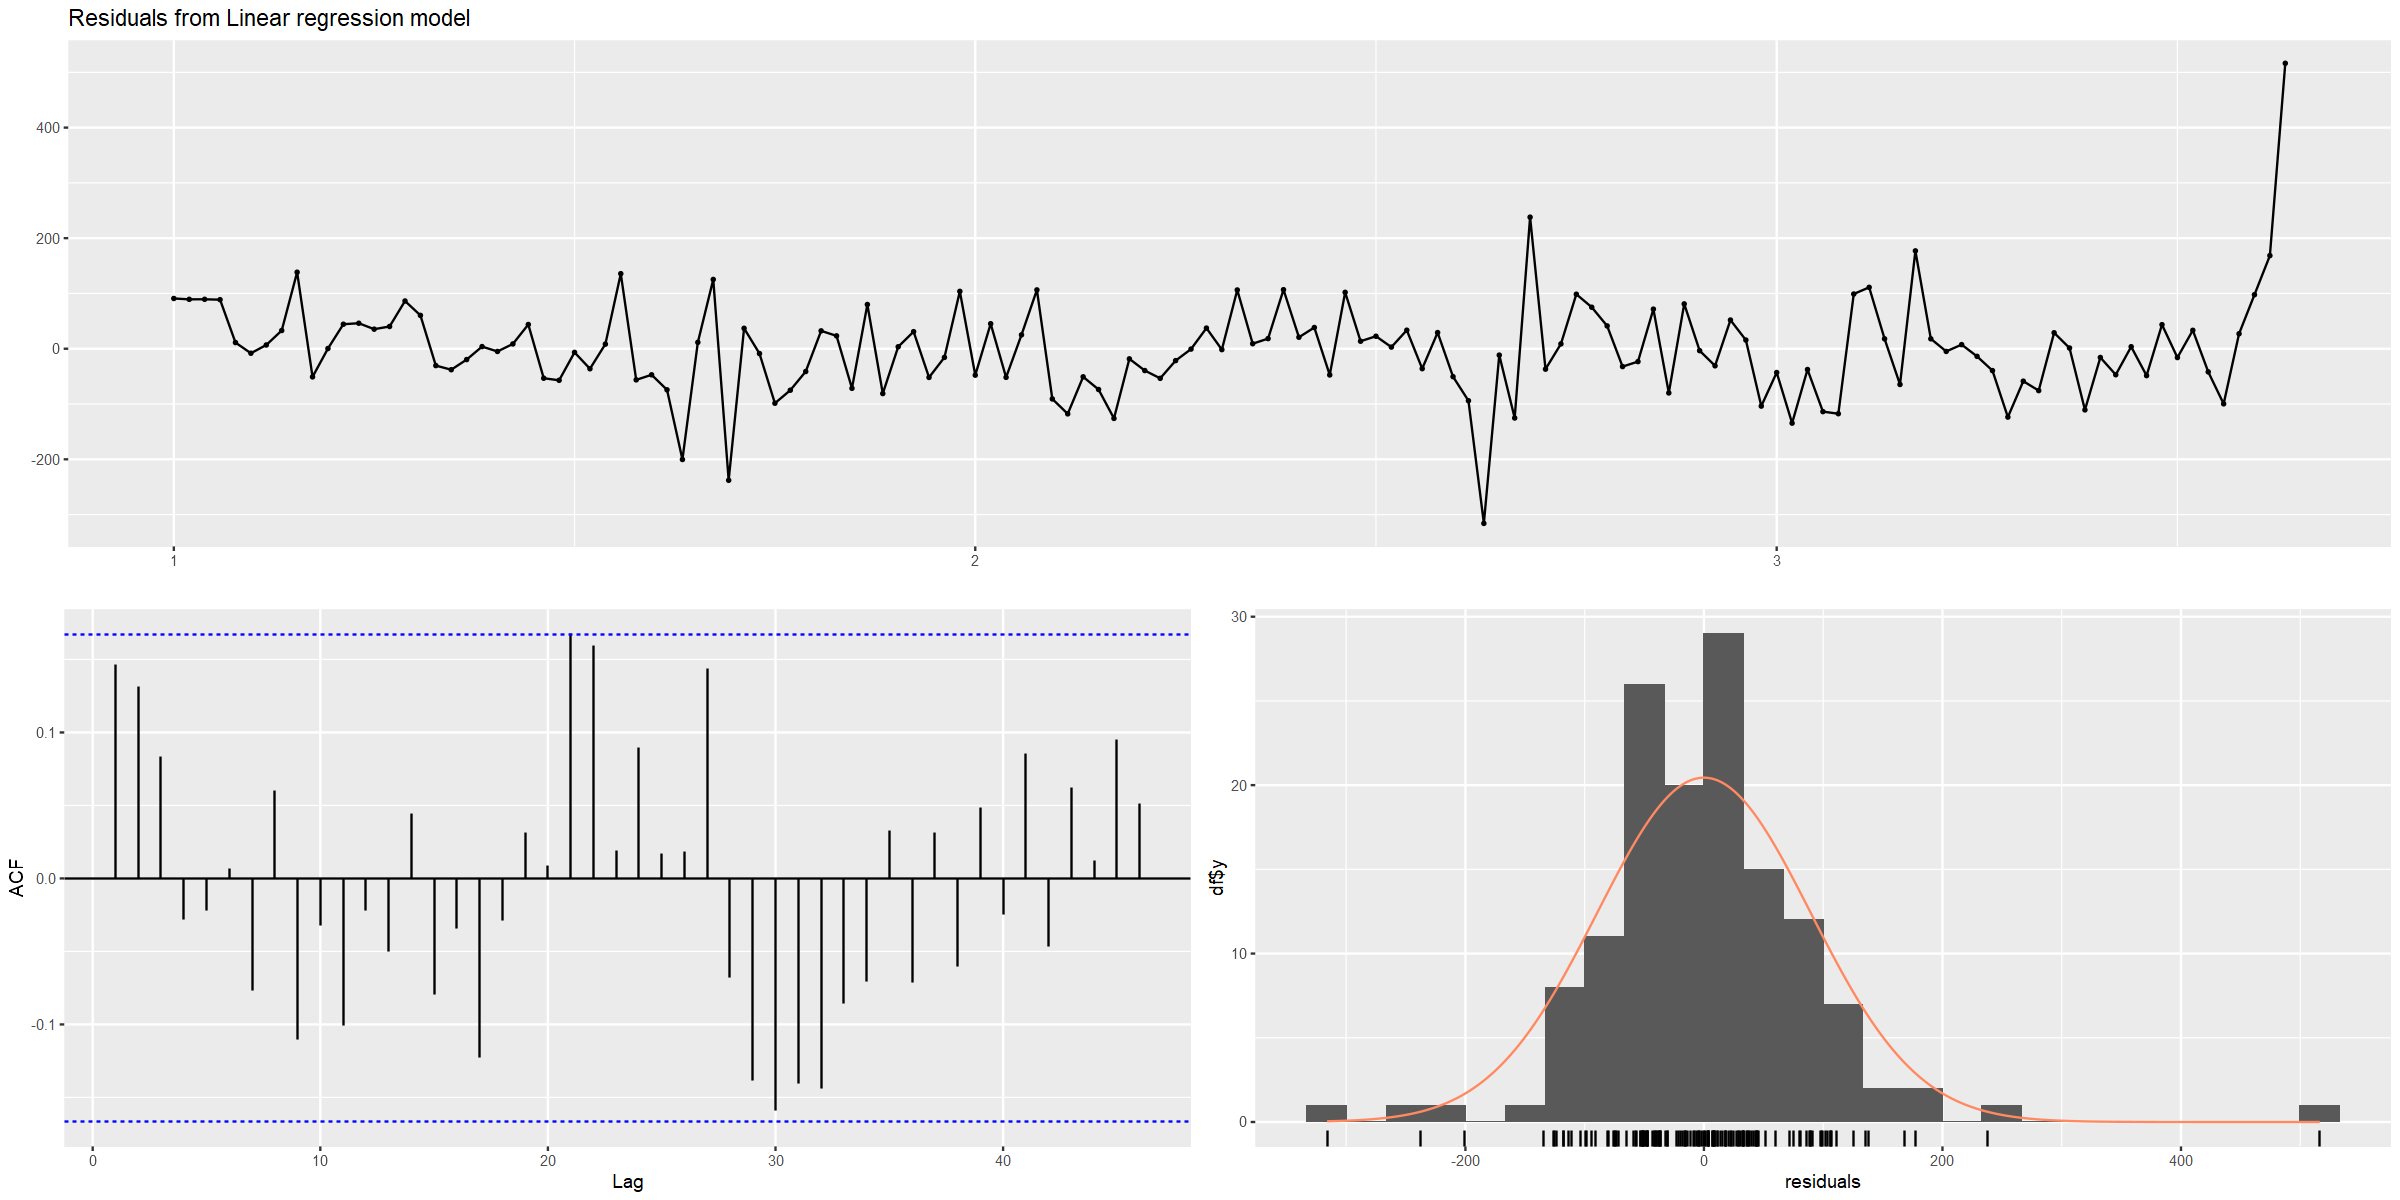

In [8]:
# Ver resuiduos ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
checkresiduals(model_tslm)

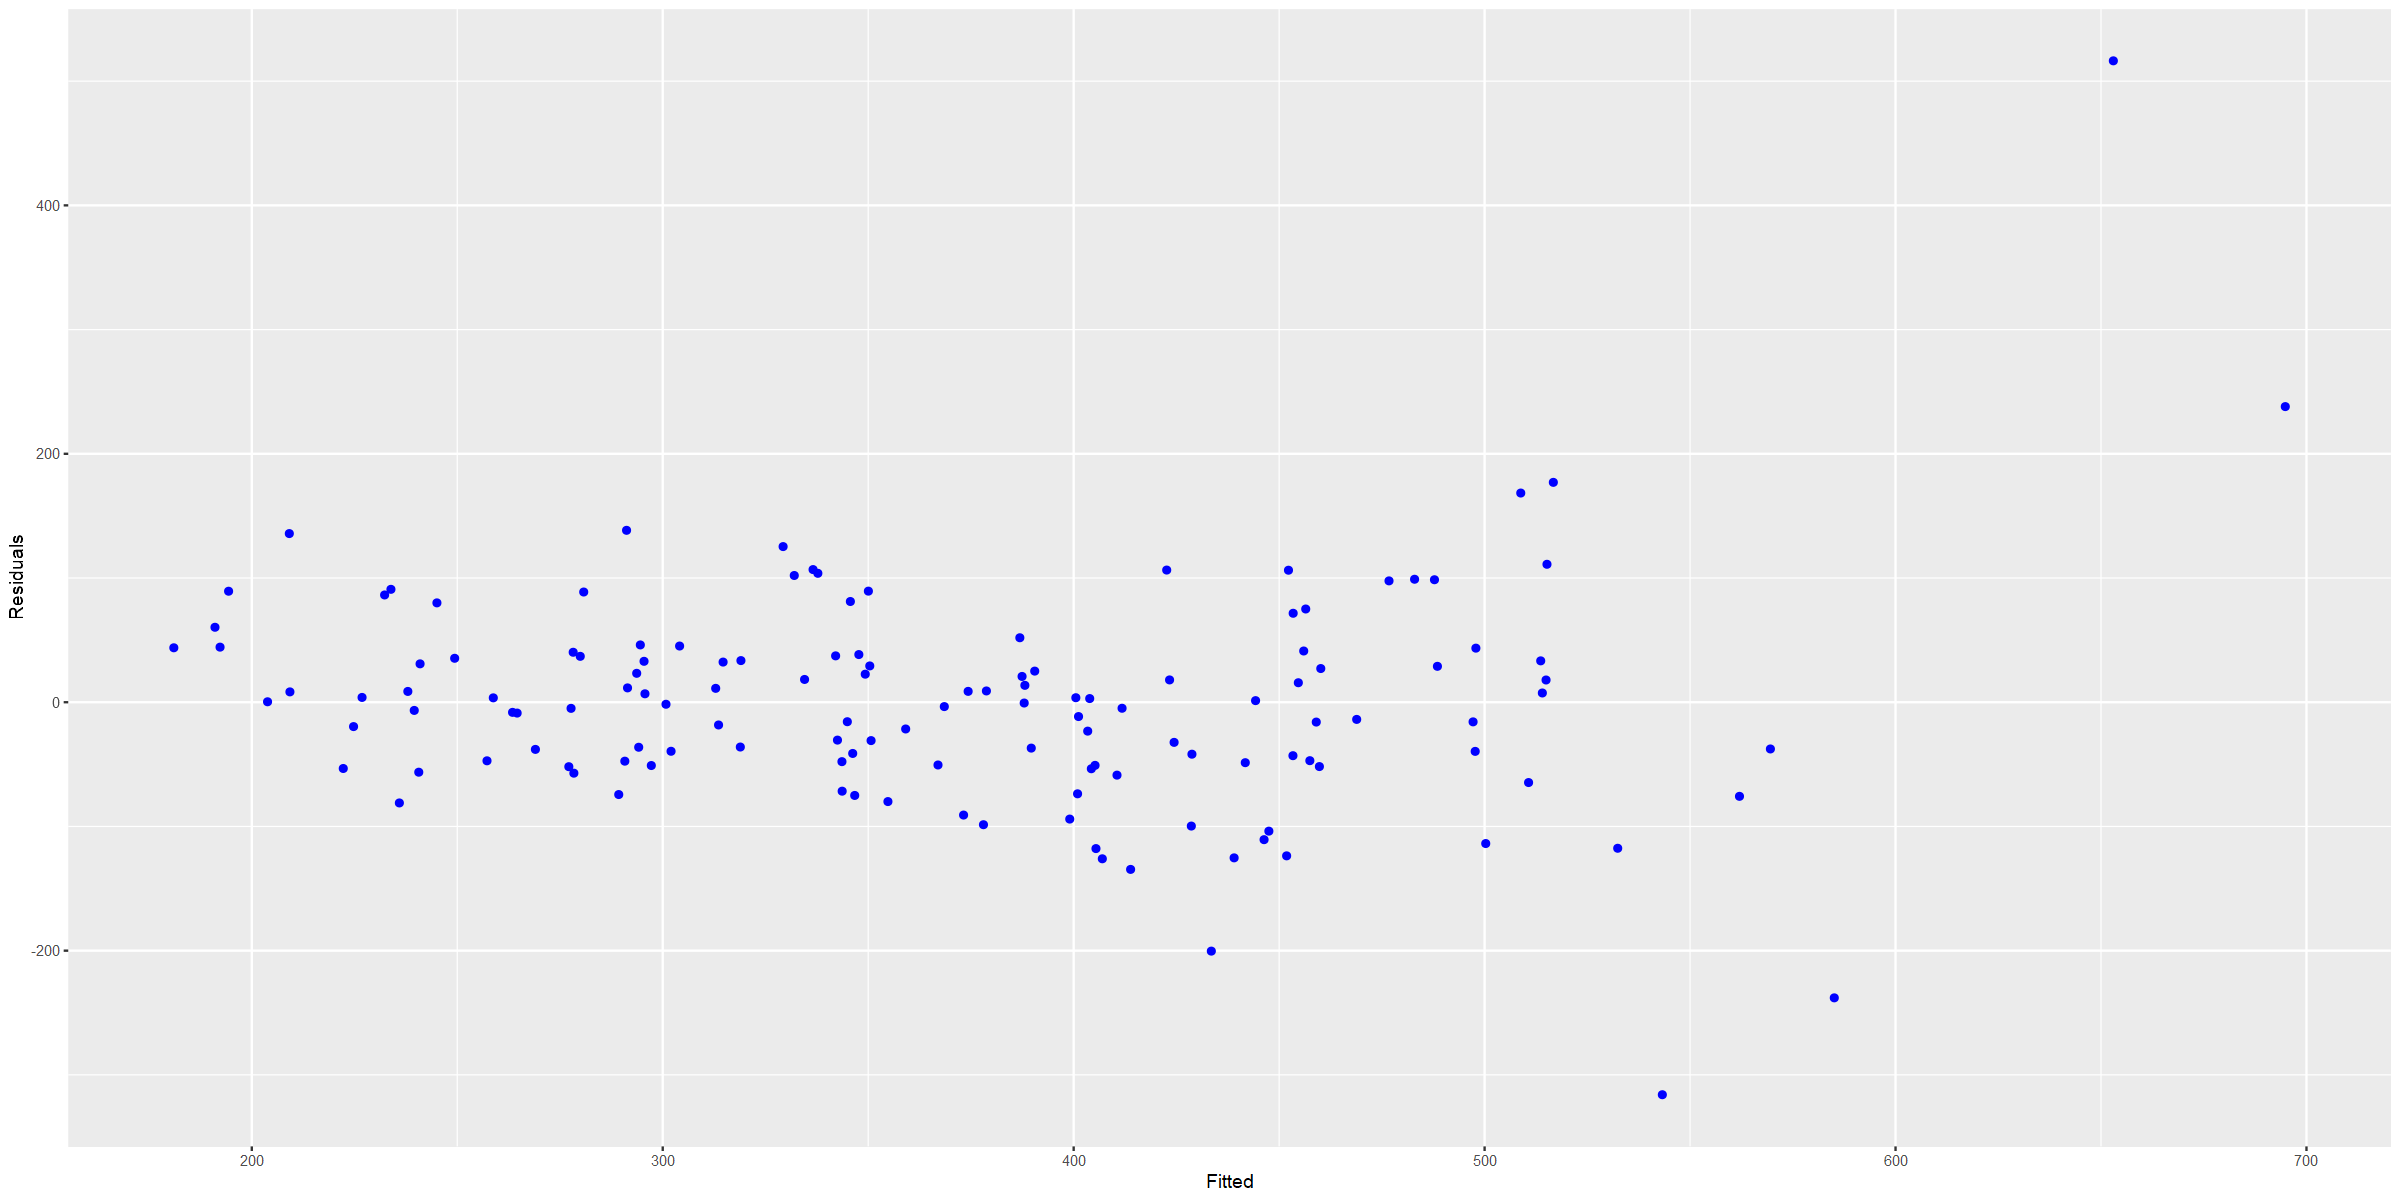

In [9]:
# Ver resíduos VS valores ajustados
cbind(Fitted = fitted(model_tslm),
      Residuals=residuals(model_tslm)) %>%
  as.data.frame() %>%
  ggplot(aes(x=Fitted, y=Residuals)) + geom_point(color = "blue")

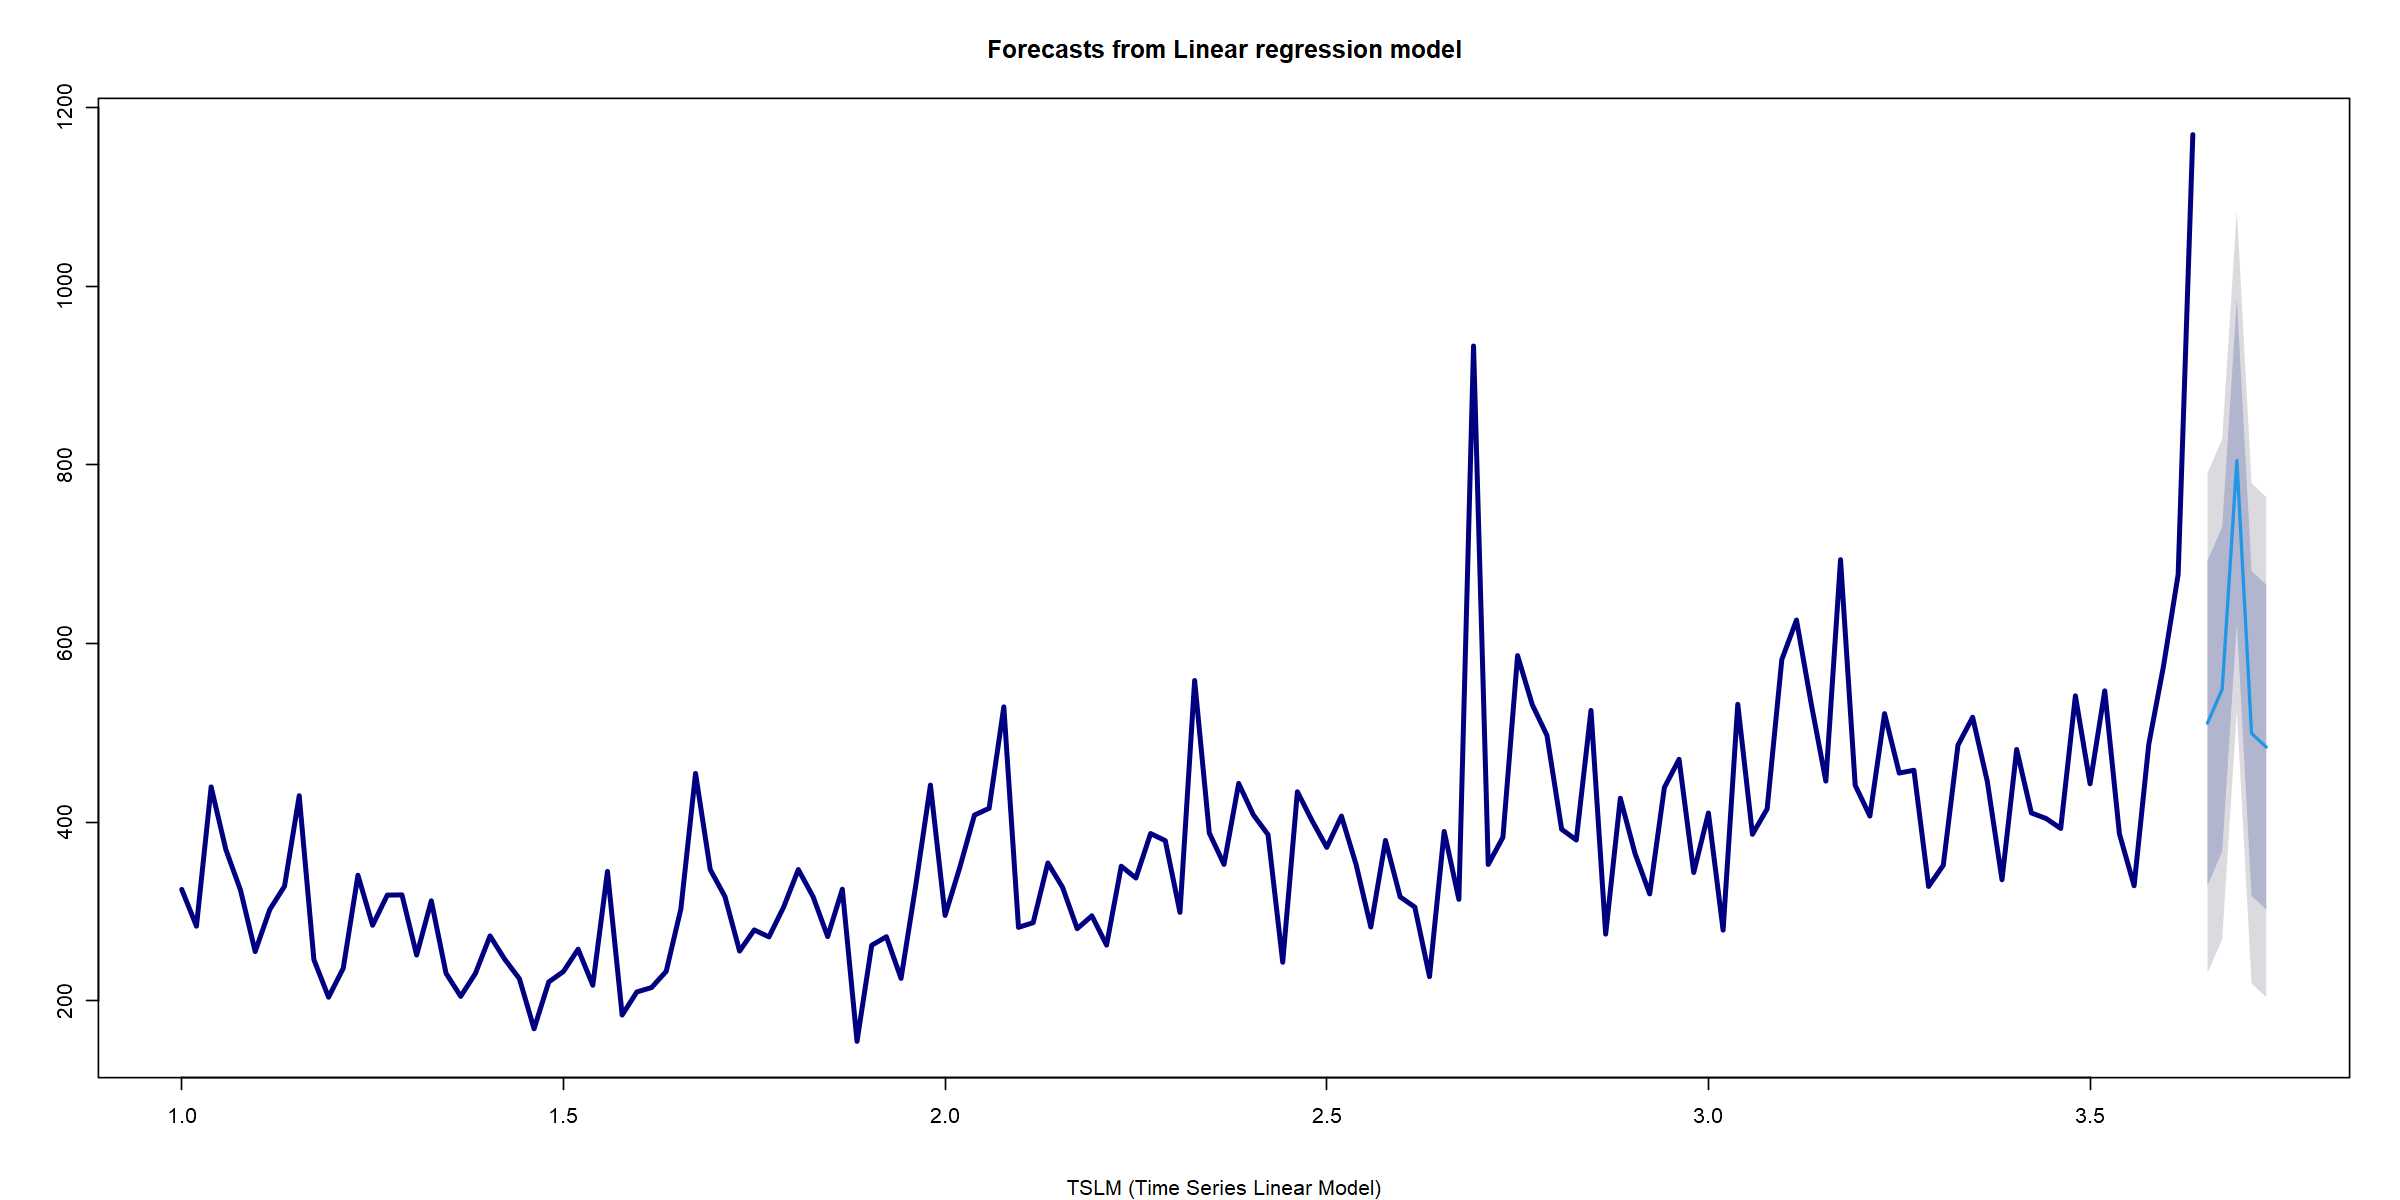

In [10]:
# Ver previsões ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
predict_tslm_model <- forecast_result
plot(predict_tslm_model,
     sub = "TSLM (Time Series Linear Model)",
     col = "navyblue",
     lwd = 3)
     

##  LM (Linear Model)

In [11]:
# Model linear regression
# Armazenar previsões lm model 
lm_prev <- list()
#loop
for (df in names(df_train)){
    data <- df_train[[df]]
    model_lm <- lm(summed_revenue ~ date, data = data)
    new_data <- data.frame(date = seq(max(data$date) + 7, length.out = 5, by = 7))
    forecast_result <- forecast(model_lm, newdata = new_data)
    previsoes <- round(forecast_result$mean,2)
    previsoes_ts <- ts(previsoes)
    lm_prev[[df]] <- previsoes_ts
}
length(lm_prev)

[1] 63

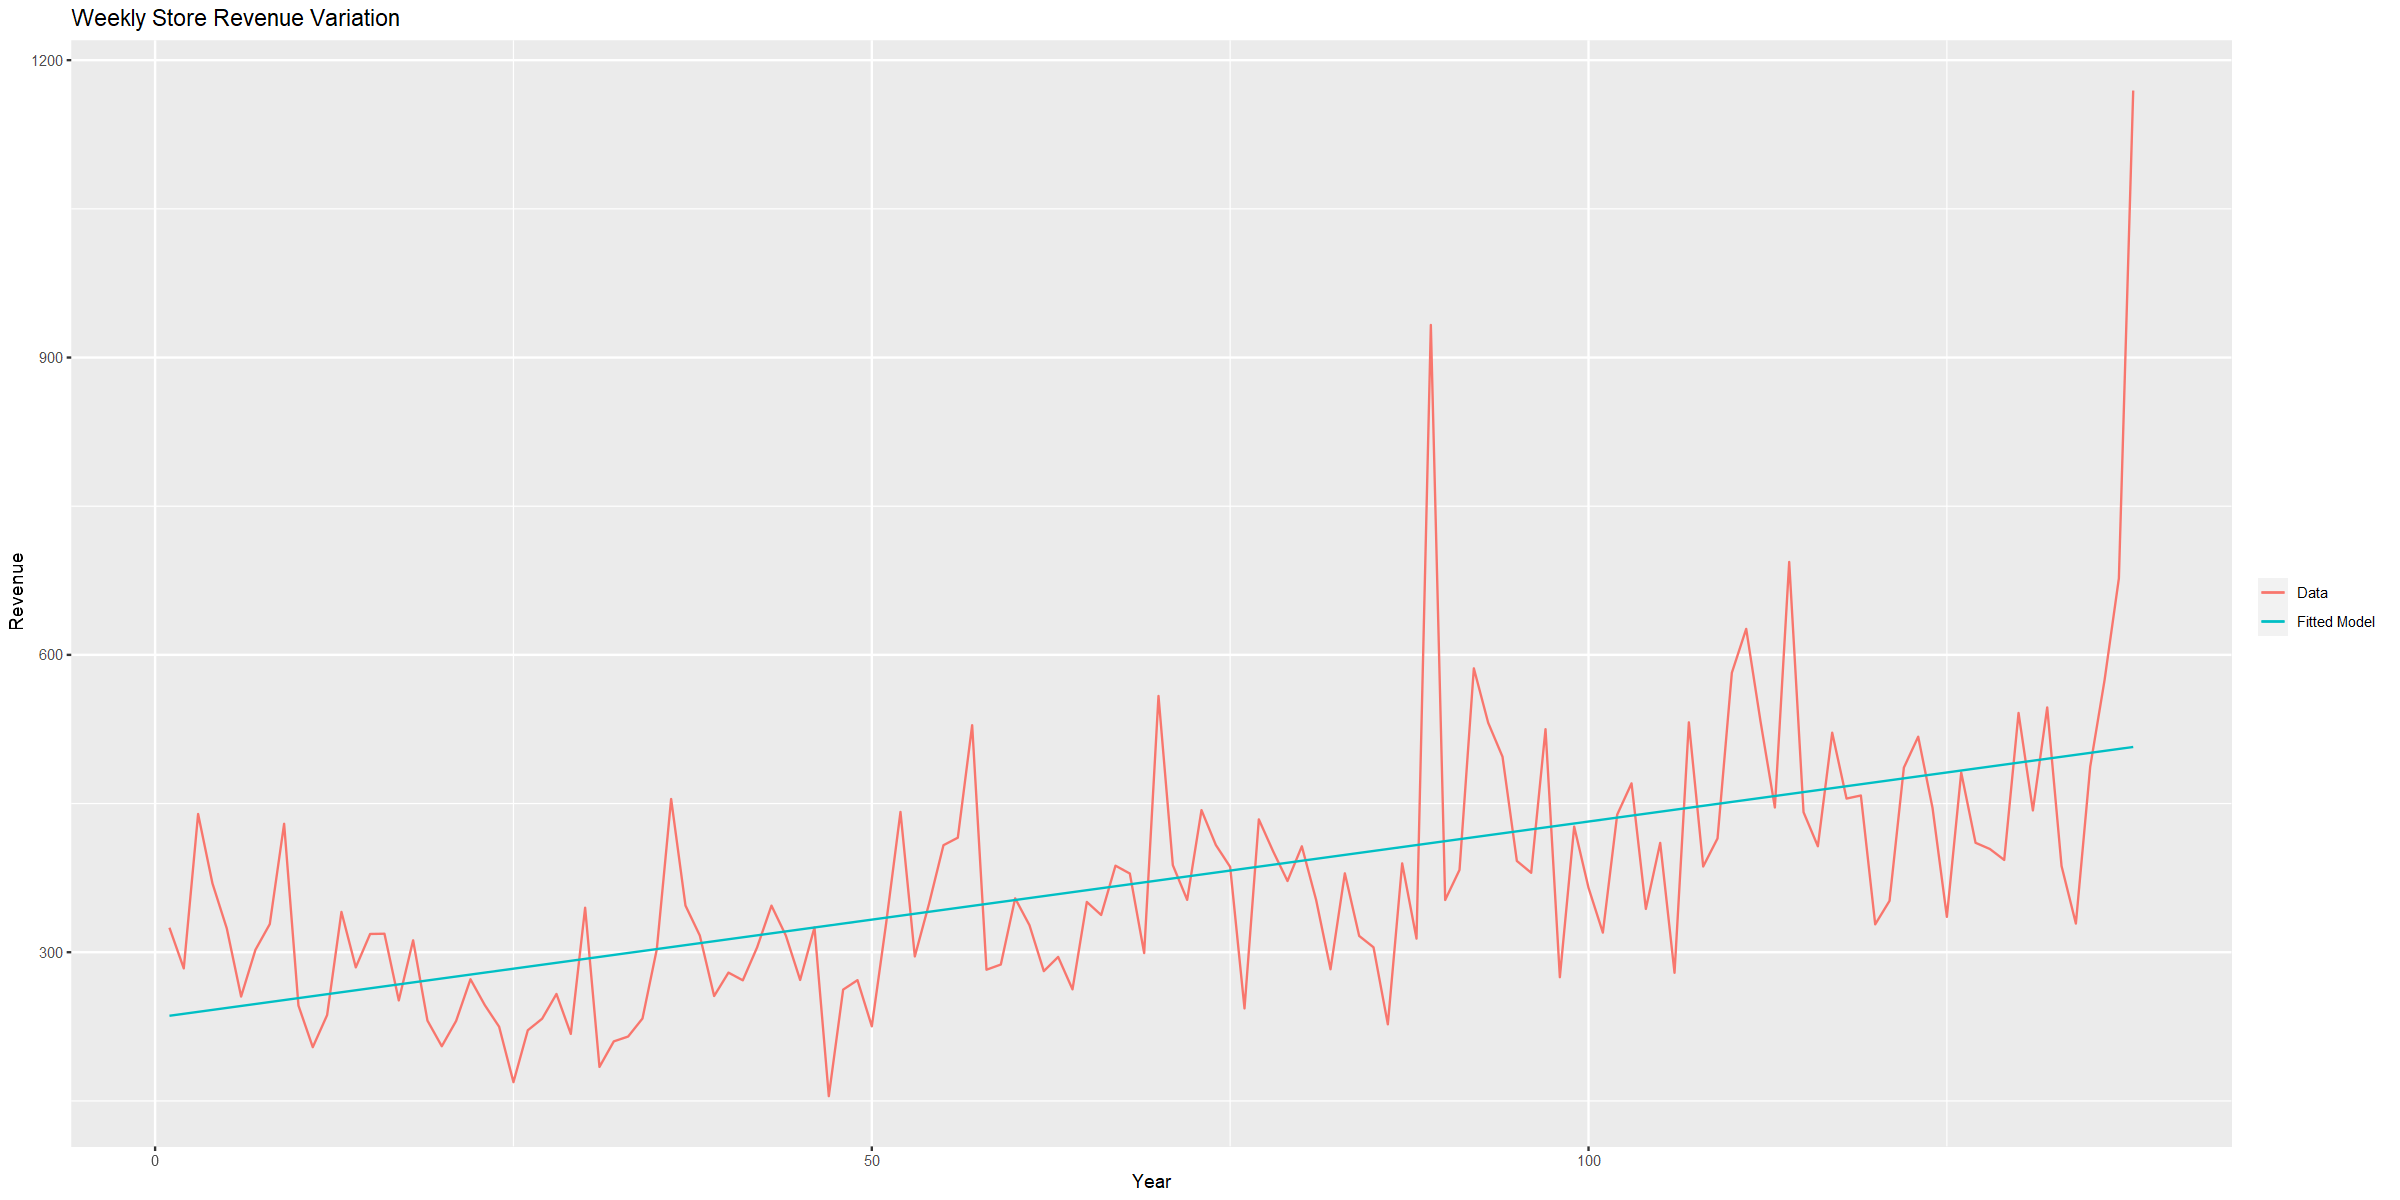

In [12]:
# Transformar variáveis em ts
revenue_ts <- ts(data[,'summed_revenue'])
ts_fitted_model <- ts(fitted(model_lm))
# Ver variação do Revenue dados modelo vs dados reais
autoplot(revenue_ts, series = "Data") +
  autolayer(ts_fitted_model, series = "Fitted Model") +
  xlab("Year") +
  ylab("Revenue") +
  ggtitle("Weekly Store Revenue Variation") +
  guides(colour = guide_legend(title = " "))

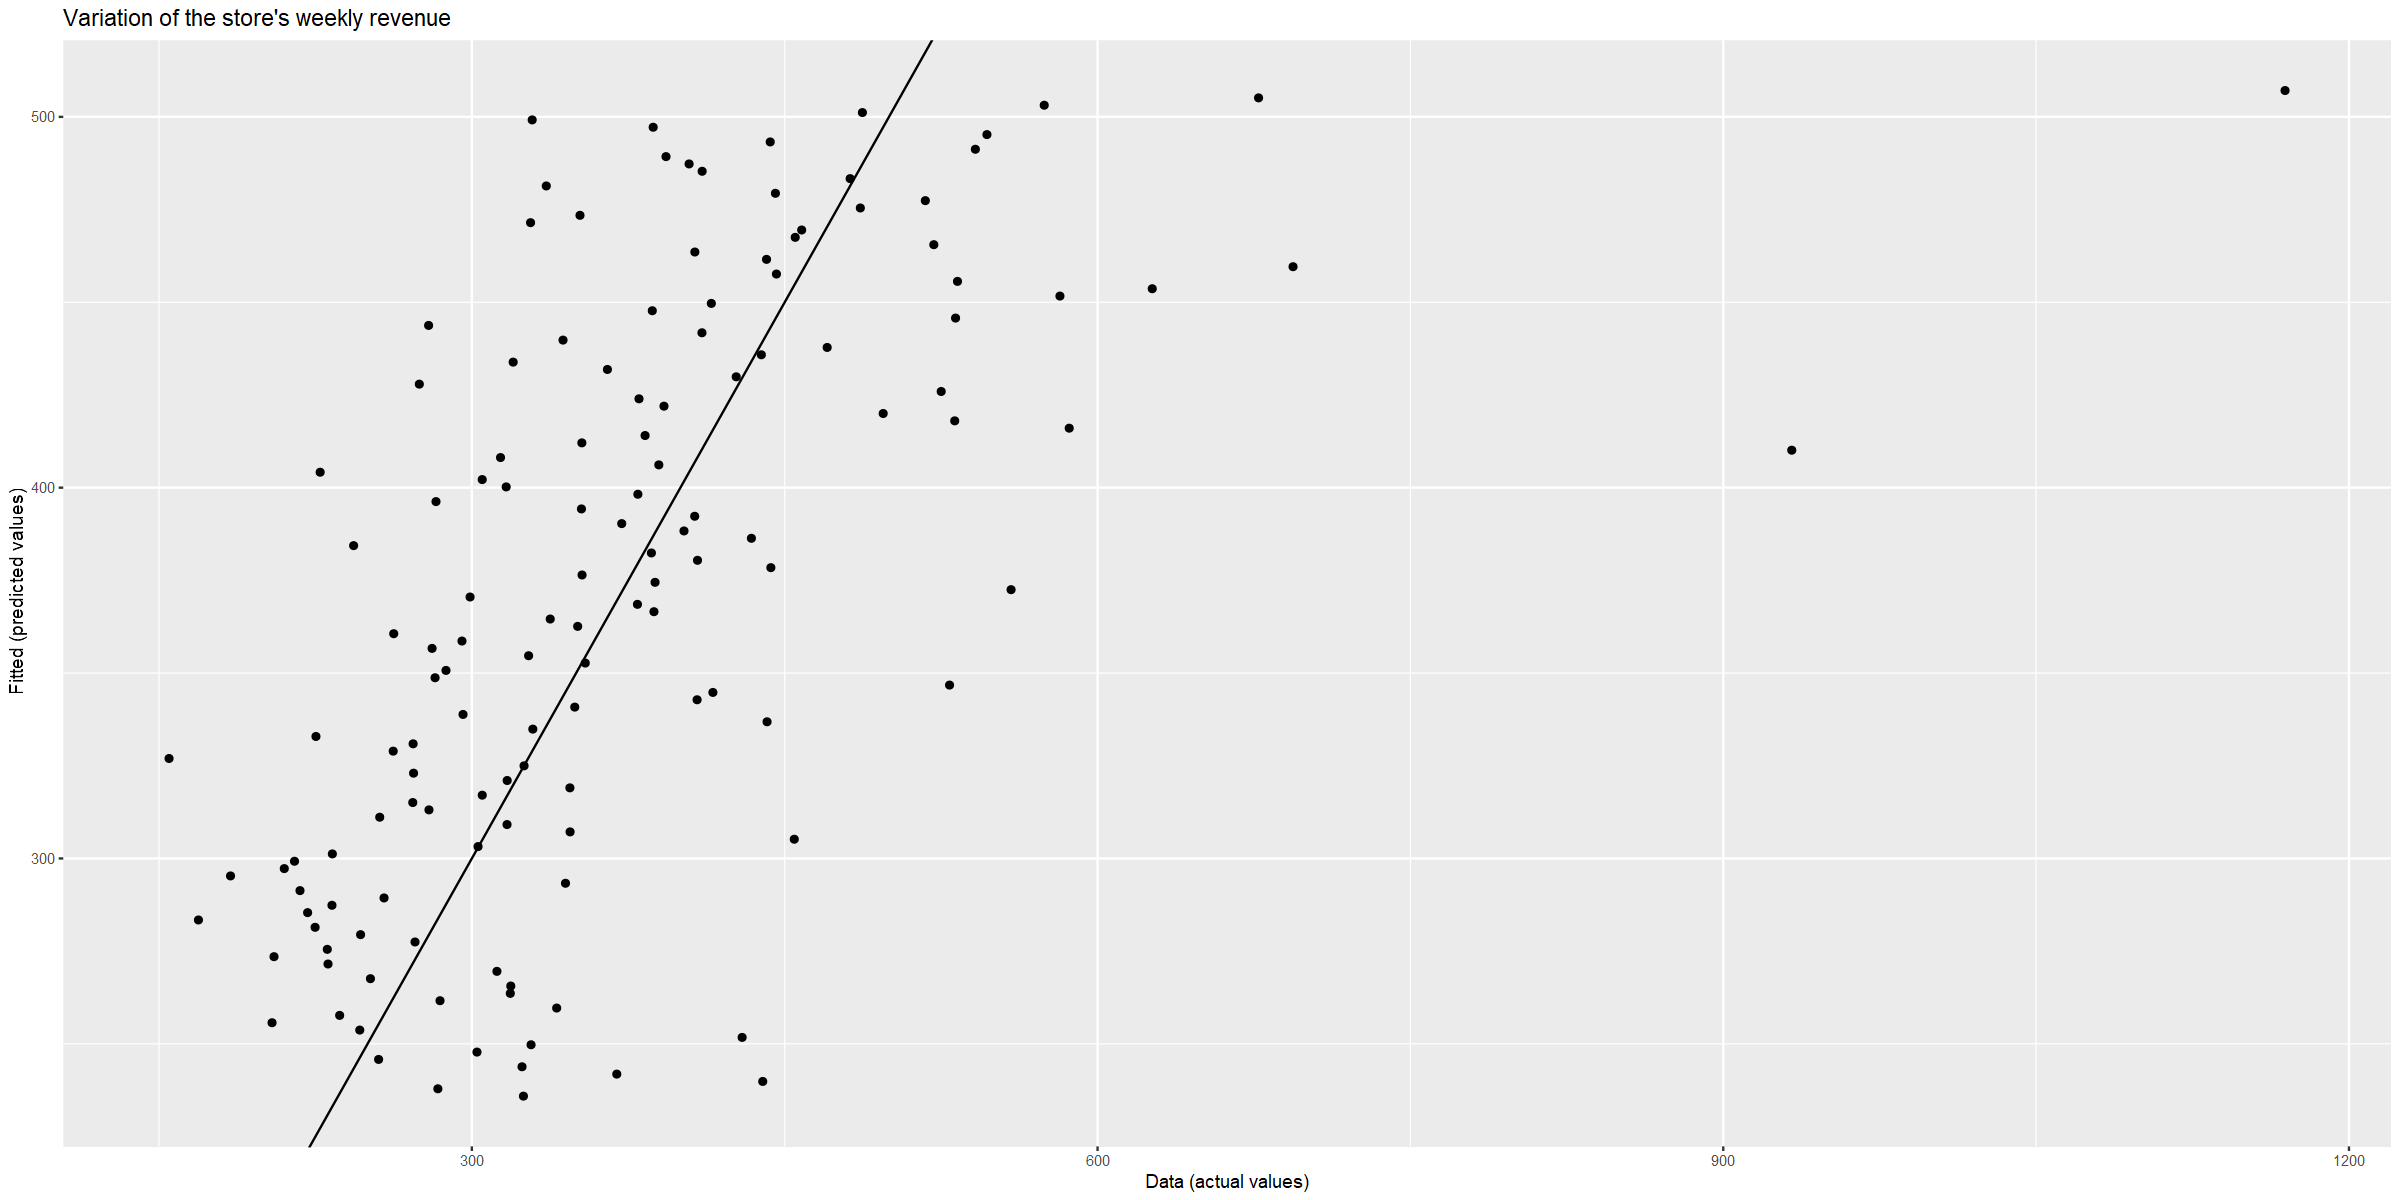

In [13]:
# Linha de regressão com intercepto zero e inclinação um, 
# que representa a linha de referência para os valores reais e previsões serem iguais
cbind(Data = revenue_ts,
      Fitted = ts_fitted_model) %>%
  as.data.frame() %>%
  ggplot(aes(x=Data, y=Fitted)) +
    geom_point() +
    ylab("Fitted (predicted values)") +
    xlab("Data (actual values)") +
    ggtitle("Variation of the store's weekly revenue") +
    geom_abline(intercept=0, slope=1)

In [14]:
# Resumo modelo ex: loja S0143
summary(model_lm)


Call:
lm(formula = summed_revenue ~ date, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-176.89  -63.30  -15.05   47.22  662.26 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.621e+03  5.958e+02  -7.756 1.85e-12 ***
date         2.828e-01  3.374e-02   8.381 5.84e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 110.5 on 136 degrees of freedom
Multiple R-squared:  0.3406,	Adjusted R-squared:  0.3357 
F-statistic: 70.24 on 1 and 136 DF,  p-value: 5.835e-14



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 12.839, df = 10, p-value = 0.2328


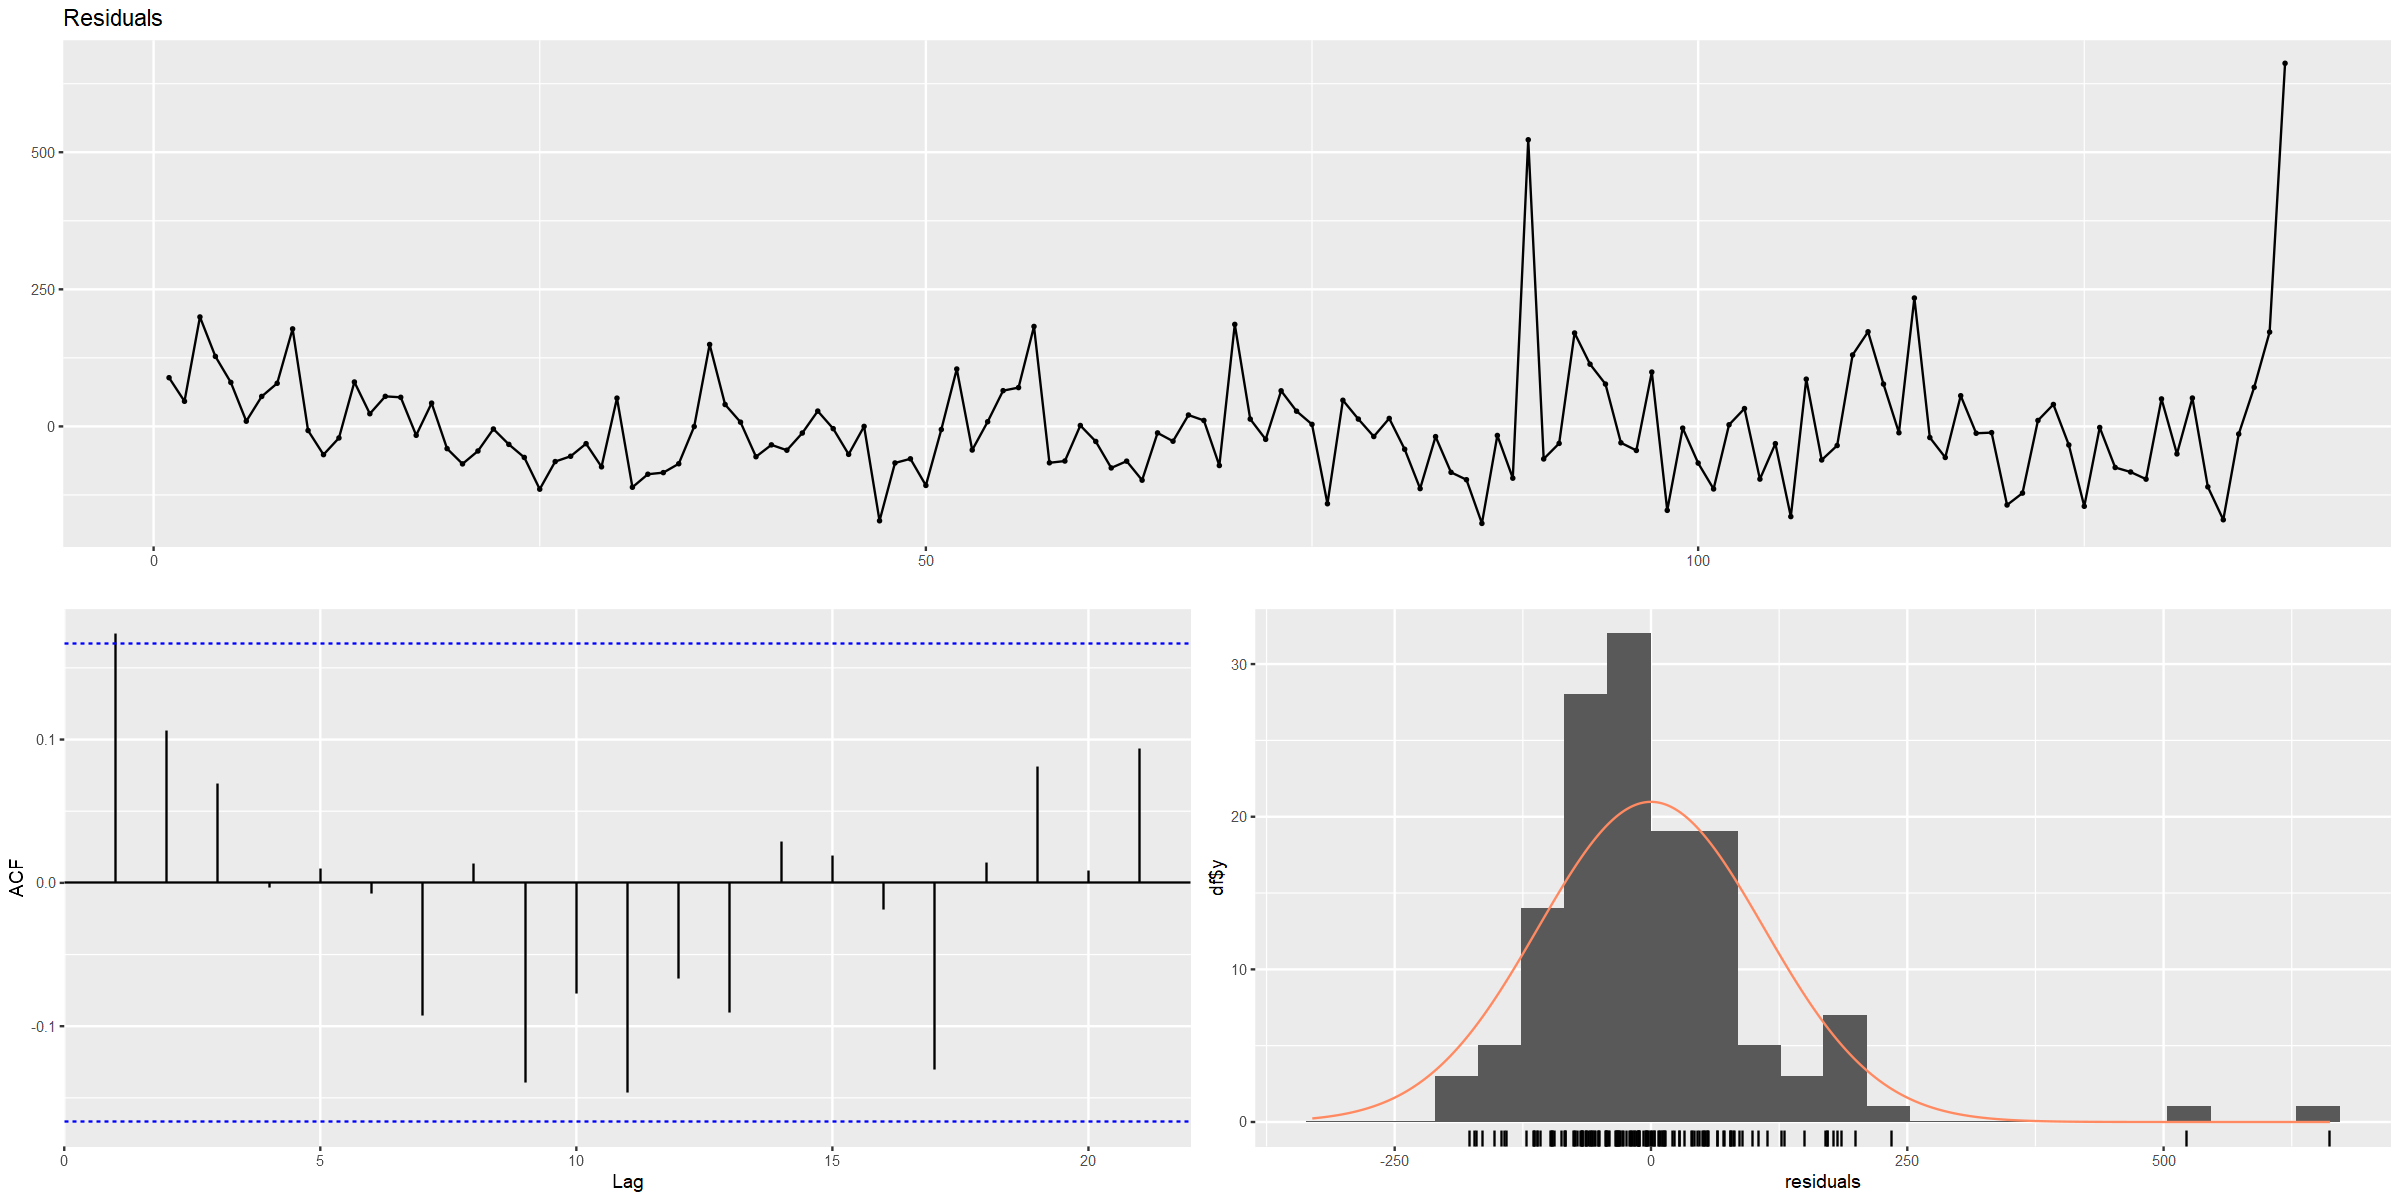

In [15]:
# Ver resuiduos ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
checkresiduals(model_lm)

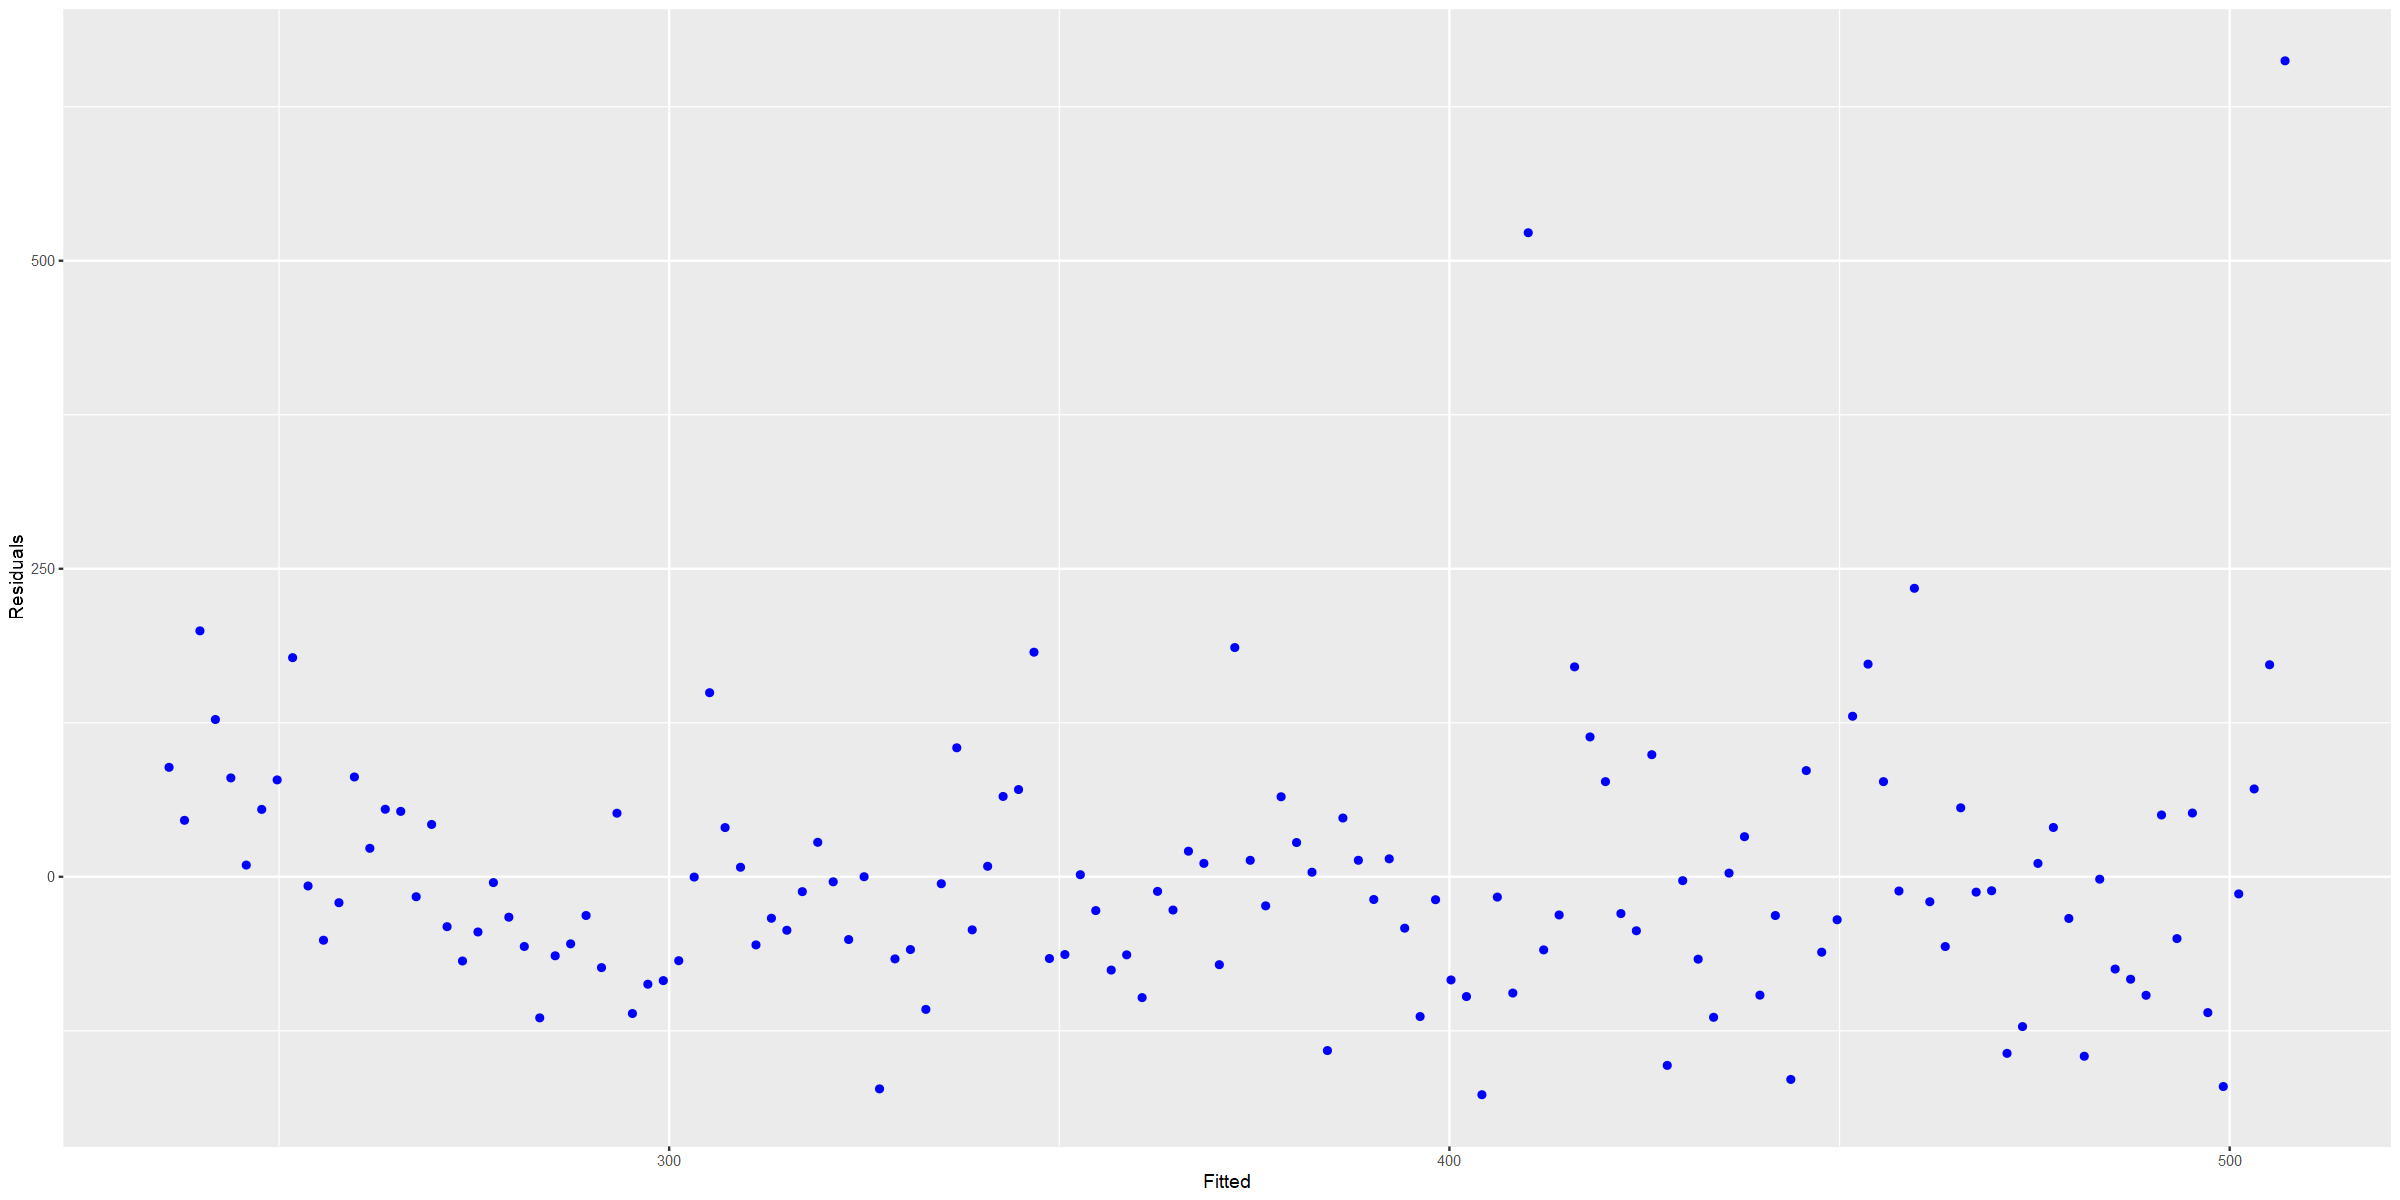

In [16]:
# Ver resíduos VS valores ajustados
# Cada ponto no gráfico representa um par de valor ajustado e resíduo correspondente
cbind(Fitted = ts_fitted_model,
      Residuals=residuals(model_lm)) %>%
  as.data.frame() %>%
  ggplot(aes(x=Fitted, y=Residuals)) + geom_point(color = "blue")

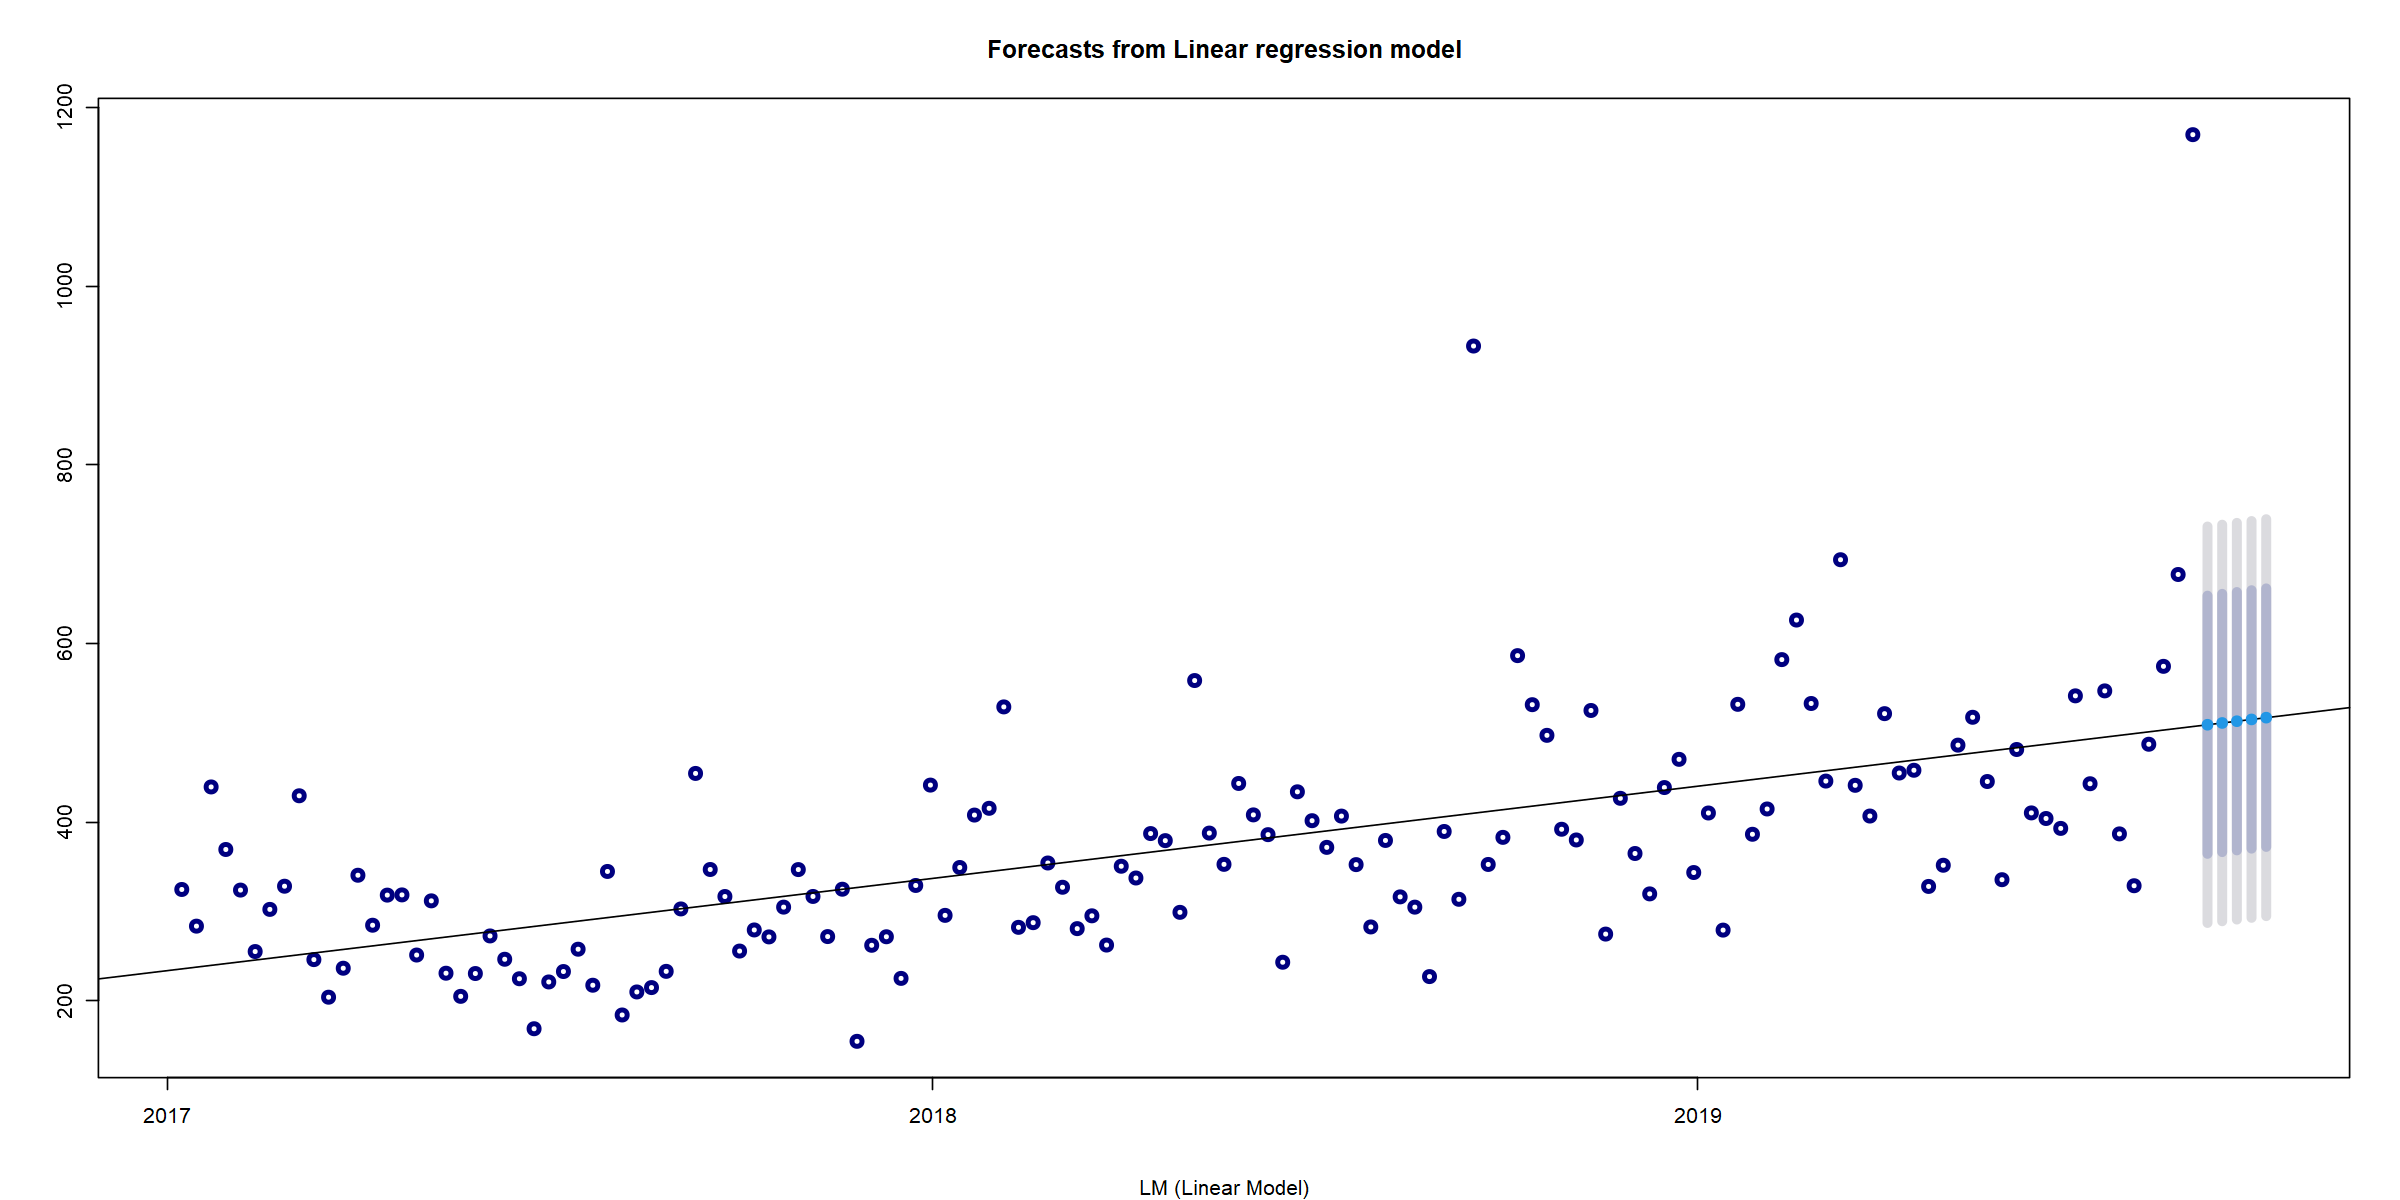

In [17]:
# Ver previsões ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
predict_lm_model <- forecast_result
plot(predict_lm_model,
     sub = "LM (Linear Model)",
     col = "navyblue",
     lwd = 3)

## Evaluation Dataframe 

In [18]:
# Criar dataframe com resultados reais
prev <- do.call(rbind, df_test)
# Inserir o nome dos dataframes como uma coluna chamada "store_id"
prev$store_id <- rep(names(df_test), sapply(df_test, nrow))
# Criar dataframe com os resultados tslm
result <- do.call(rbind, tslm_prev)
store_id <-names(tslm_prev)
# Combinação do índice com a matriz
result_tslm <- data.frame(store_id = store_id, result)
result_tslm <- result_tslm %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "tslm_revenue")
# Criar dataframe com os resultados lm
result <- do.call(rbind, lm_prev)
store_id <-names(lm_prev)
# Combinação do índice com a matriz
result_lm <- data.frame(store_id = store_id, result)
result_lm <- result_lm %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "lm_revenue")
# Juntar resultados num dataframe prev
prev$tslm_revenue <- result_tslm$tslm_revenue
prev$lm_revenue <- result_lm$lm_revenue
head(prev,10)

,store_id,date,summed_revenue,tslm_revenue,lm_revenue
,<chr>,<date>,<dbl>,<dbl>,<dbl>
S0002.139,S0002,2019-09-01,4164.56,3821.19,4579.81
S0002.140,S0002,2019-09-08,6267.91,3985.06,4598.77
S0002.141,S0002,2019-09-15,5007.57,6440.11,4617.72
S0002.142,S0002,2019-09-22,3074.56,3859.27,4636.68
S0002.143,S0002,2019-09-29,5728.25,4213.90,4655.63
S0003.282,S0003,2019-09-01,1030.02,1085.29,1303.42
S0003.283,S0003,2019-09-08,1302.61,1240.69,1309.59
S0003.284,S0003,2019-09-15,1255.40,2220.28,1315.75
S0003.285,S0003,2019-09-22,1343.15,1260.44,1321.92


## Visualização de previsões e dados reais

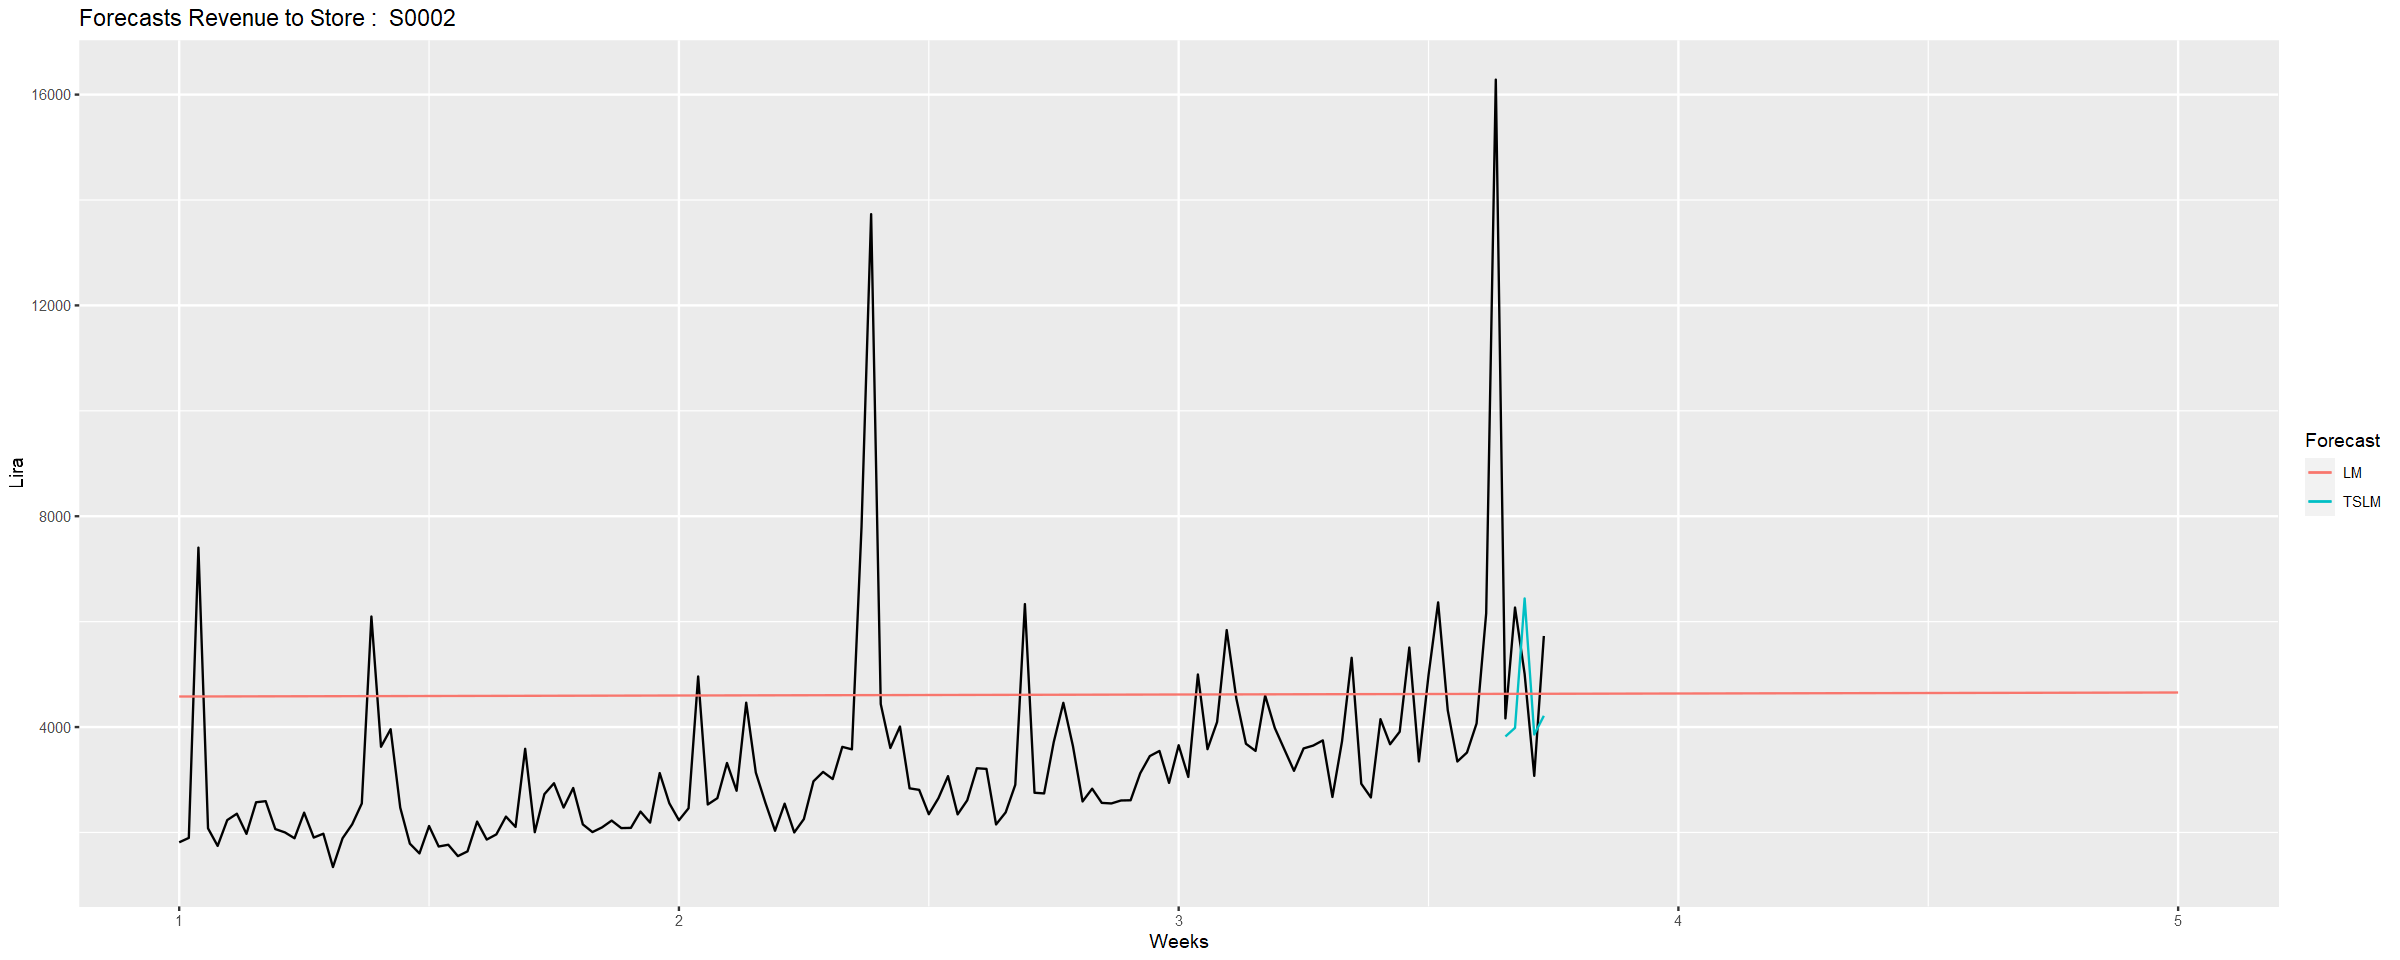

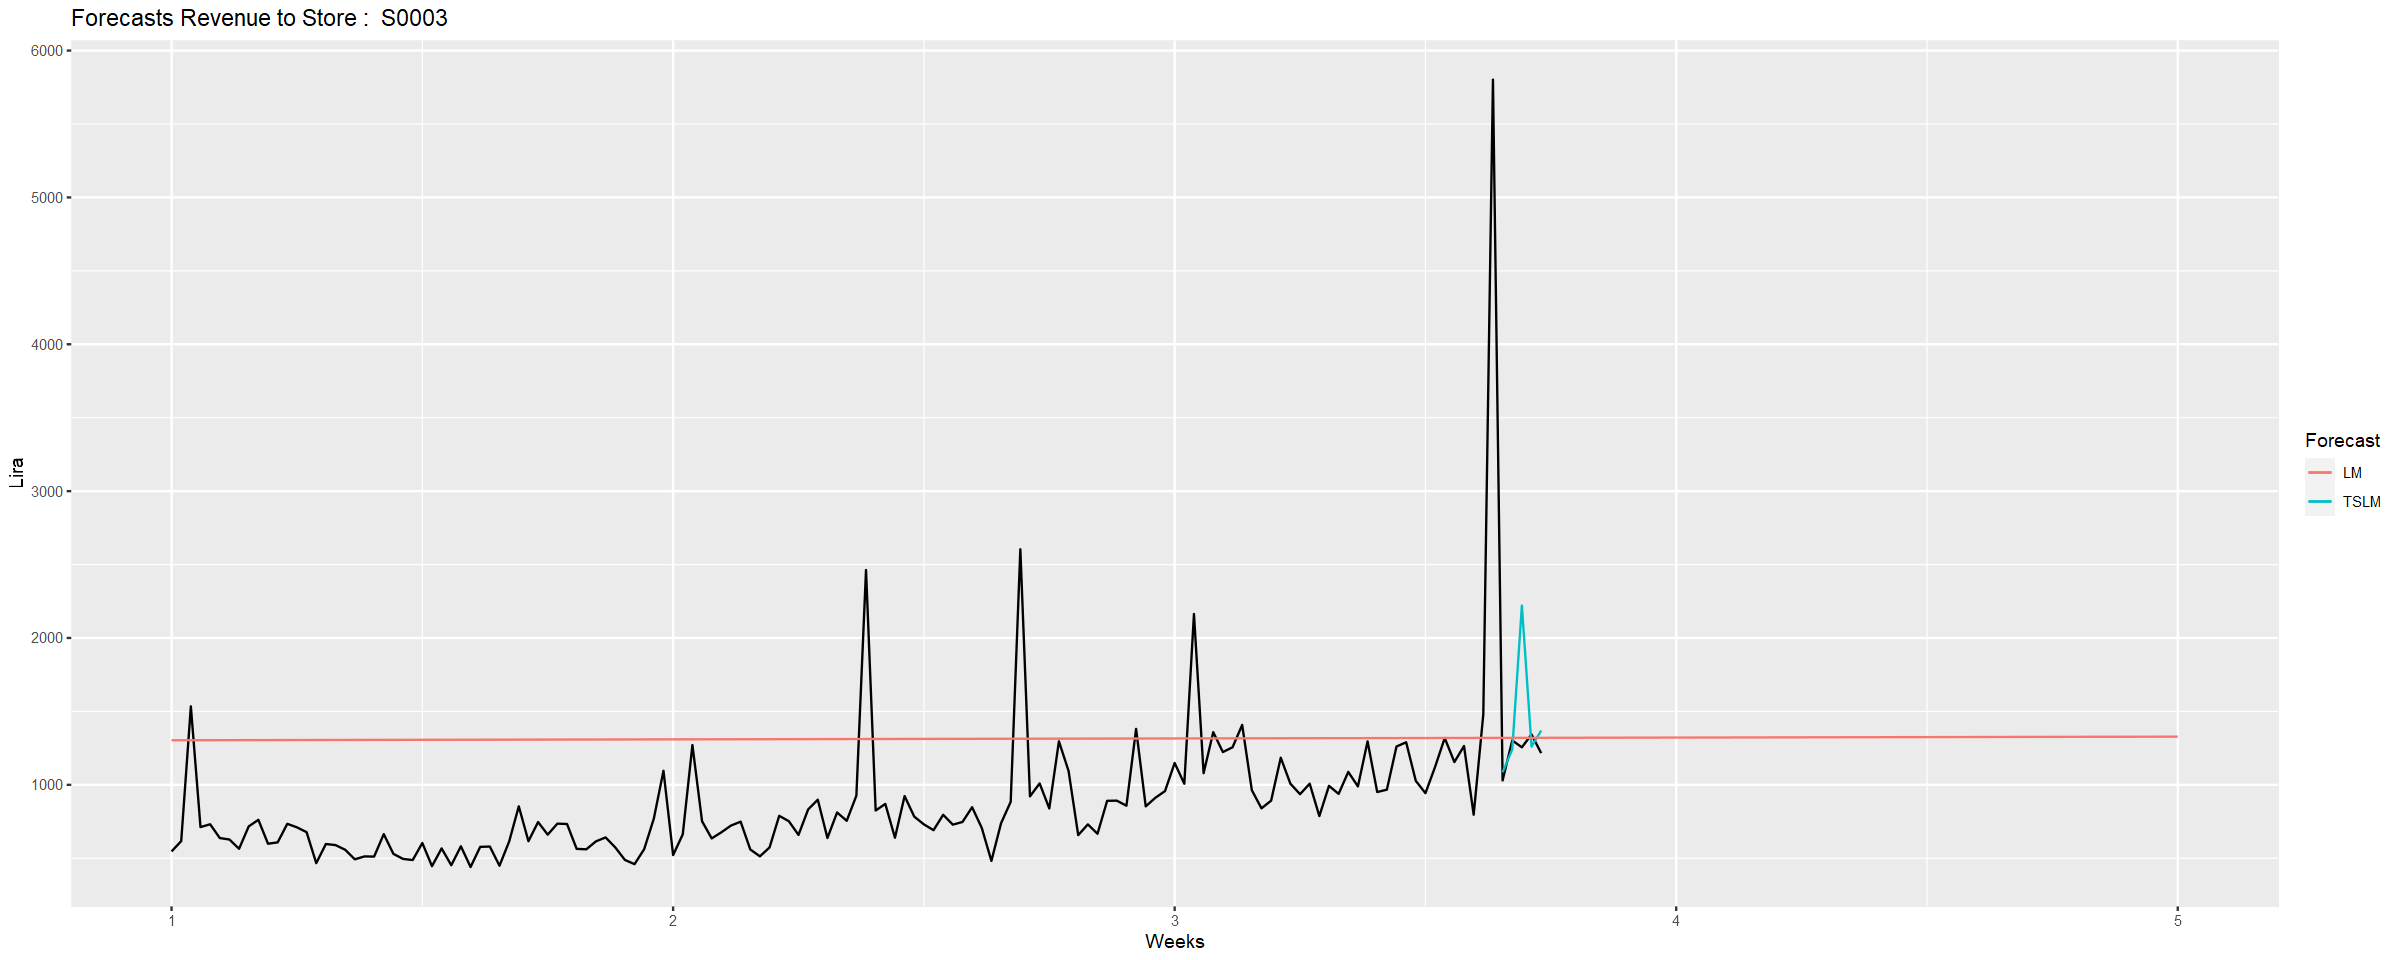

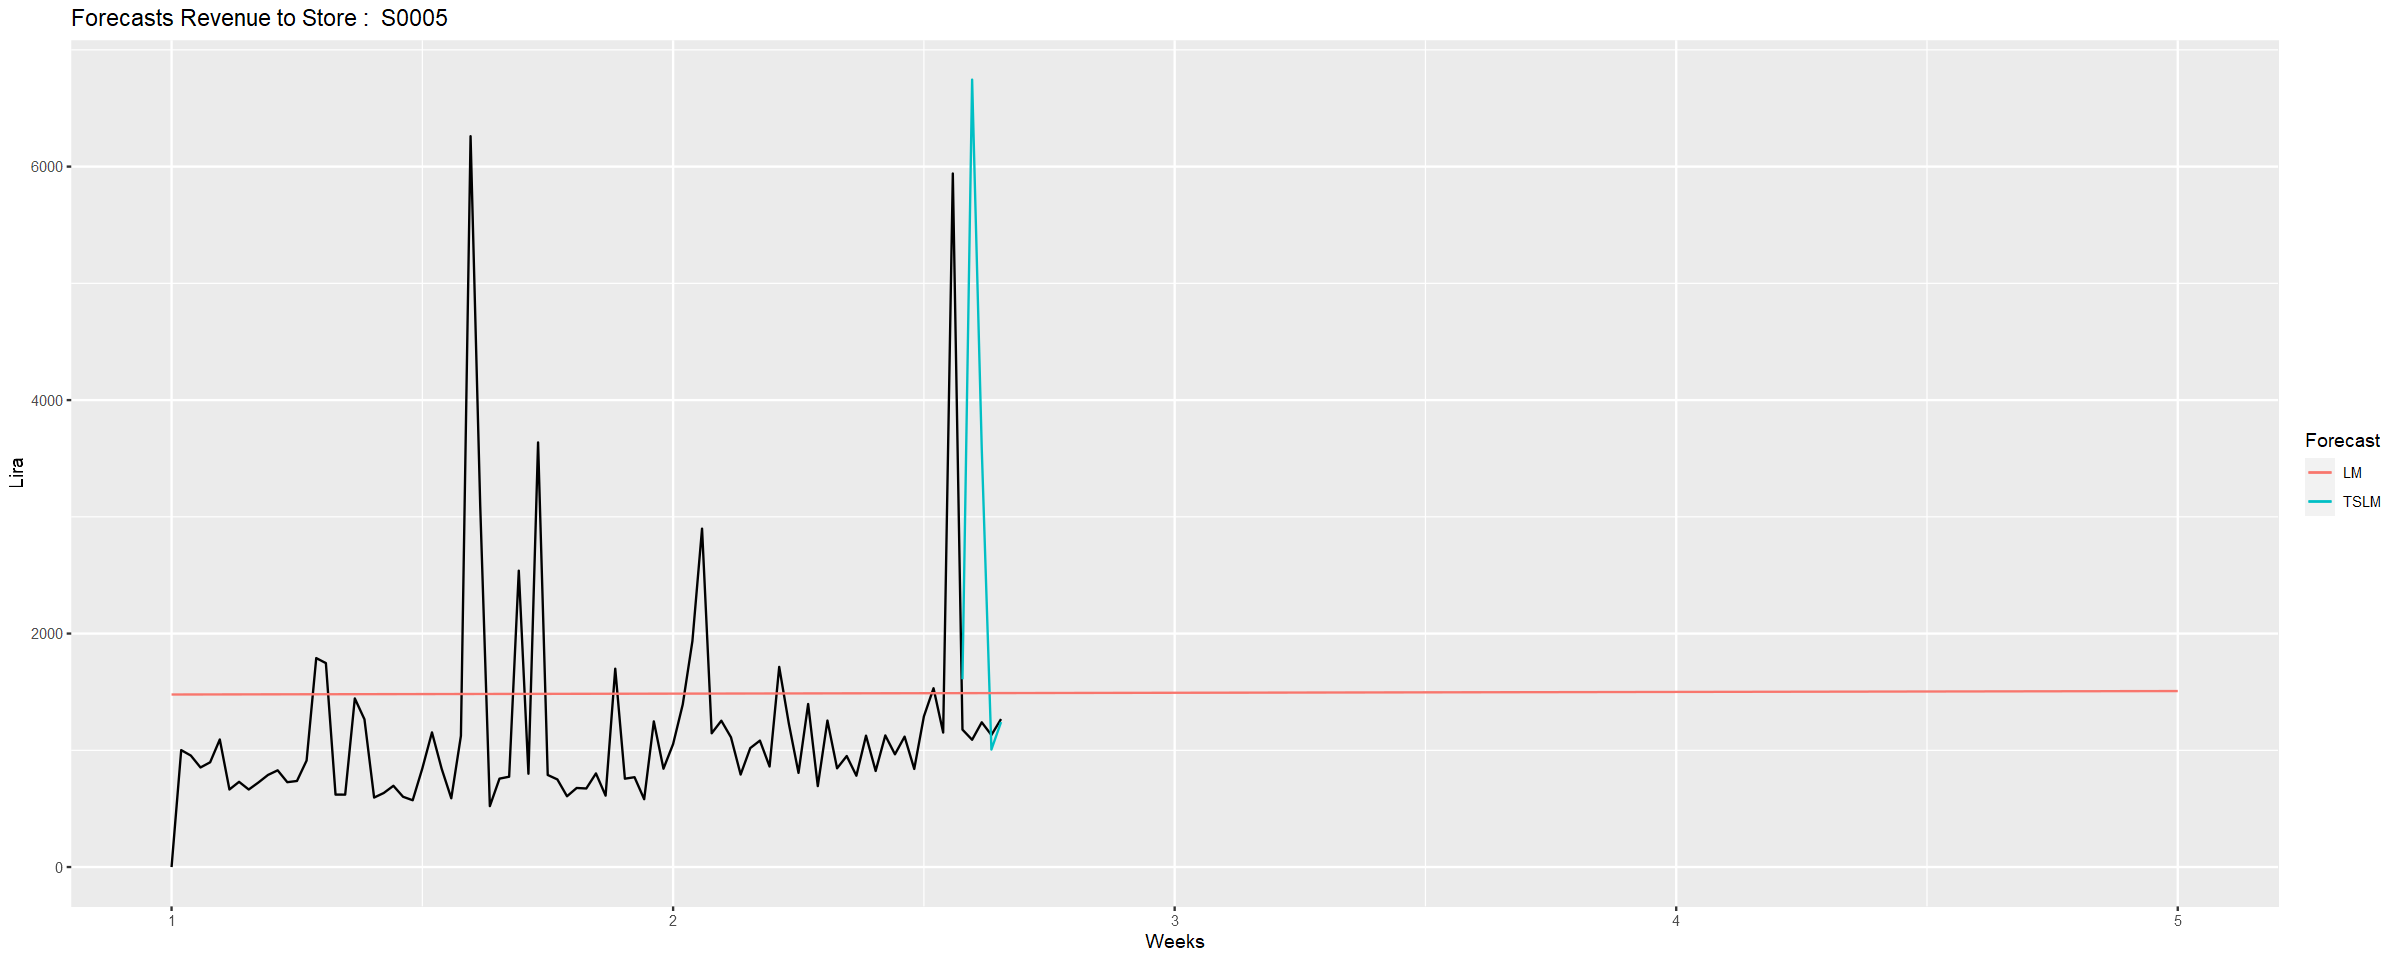

In [19]:
# Ver graficamente as previsões para 3 lojas
options(repr.plot.width = 20, repr.plot.height = 8)
for (i in 1:length(ts_train)) {
  ts_name <- names(ts_train)[i]
  ts <- ts_train[[ts_name]]
  if (i <= 3) {
    plot <- autoplot(ts_real[[ts_name]]) +
    autolayer(tslm_prev[[ts_name]], series = "TSLM")+
    autolayer(lm_prev[[ts_name]], series = "LM")+
    ggtitle(paste("Forecasts Revenue to Store : ",ts_name))+
    xlab("Weeks") + ylab("Lira") +
    guides(colour=guide_legend(title="Forecast"))  
    print(plot)
  }
}

## Evaluation


In [20]:
# Criar uma lista para armazenar as métricas de accuracy
accuracy_list_lm <- list()
accuracy_list_tslm <- list()
# Calcular a accuracy para modelos lm
for (ts in names(lm_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(lm_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_lm[[ts]] <- accuracy
}
# Calcular a accuracy para modelos tslm
for (ts in names(tslm_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(tslm_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_tslm[[ts]] <- accuracy
}
# Converter a lista de accuracy em um DataFrame
df_accuracy_lm <- do.call(rbind, accuracy_list_lm)
df_accuracy_tslm <- do.call(rbind, accuracy_list_tslm)
# Adicionar coluna "store_id" com os valores de ts
df_accuracy_lm <- cbind(store_id = names(lm_prev), df_accuracy_lm)
df_accuracy_lm <- as.data.frame(df_accuracy_lm, row.names = NULL)
df_accuracy_tslm <- cbind(store_id = names(tslm_prev), df_accuracy_tslm)
df_accuracy_tslm <- as.data.frame(df_accuracy_tslm, row.names = NULL)
# Adicionar sufixo  colunas
colnames(df_accuracy_lm)[-1] <- paste(colnames(df_accuracy_lm)[-1], "_lm", sep = "")
colnames(df_accuracy_tslm)[-1] <- paste(colnames(df_accuracy_tslm)[-1], "_tslm", sep = "")
# Merge Dataframes
df_combined <- merge(df_accuracy_lm, df_accuracy_tslm, by = "store_id")
head(df_combined)

,store_id,ME_lm,RMSE_lm,MAE_lm,MPE_lm,MAPE_lm,ME_tslm,RMSE_tslm,MAE_tslm,MPE_tslm,MAPE_tslm
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,S0002,-230.848,1157.68531850413,1021.796,-5.00391637613228,22.1068985604058,-384.664,1434.60821394554,1271.564,-11.9262044812862,28.9570644762751
2,S0003,86.37,135.286095590049,94.862,6.58976717167153,7.23216610655412,205.858,440.083726283988,263.71,9.64511359364844,14.2662197890949
3,S0005,311.602,317.641477297912,311.602,20.8844281677684,20.8844281677684,1655.776,2744.68499147716,1715.804,32.326263253154,38.094951278502
4,S0007,79.882,136.839394547038,108.358,8.36986836881944,11.2164151465117,79.882,136.839394547038,108.358,8.36986836881944,11.2164151465117
5,S0010,82.2320000000001,444.729585253781,337.308,2.78666765858205,11.3442835126293,-42.852,481.585674080947,447.752,-2.19158421237799,15.971085783924
6,S0012,182.912,333.939525962411,236.496,9.5472737685548,12.3395639369843,260.06,383.253906281462,339.772,12.3352218971446,16.8047612730733


In [21]:
# Exportar resultados
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "accuracySimpleLineaRegressionModels.csv")
write.csv(df_combined, file = path, row.names = FALSE)
# Resultado previsões em dados teste
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "resultSimpleMethods.csv")
write.csv(prev, file = path, row.names = FALSE)
print('Exportação concluida!')

[1] "Exportação concluida!"
